In [1]:
pip install opencv-python matplotlib torch torchvision pycocotools


In [2]:
pip install ultralytics


Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
print(torch.cuda.is_available())


True


#### DATASET FOLDER STRUCTURE CREATION

In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Configuration
original_folders = [r"C:\Users\cl502_09\Desktop\MVGAN\TrafficSiignDetection\task1train540p", r"C:\Users\cl502_09\Desktop\MVGAN\TrafficSiignDetection\task2train540p"]  # Your current folders
dataset_path = 'dataset'                   # New structured dataset
test_size = 0.15                           # 15% for test
val_size = 0.15                            # 15% for validation

# Create new directory structure
os.makedirs(os.path.join(dataset_path, 'train', 'images'), exist_ok=True)
os.makedirs(os.path.join(dataset_path, 'train', 'labels'), exist_ok=True)
os.makedirs(os.path.join(dataset_path, 'val', 'images'), exist_ok=True)
os.makedirs(os.path.join(dataset_path, 'val', 'labels'), exist_ok=True)
os.makedirs(os.path.join(dataset_path, 'test', 'images'), exist_ok=True)
os.makedirs(os.path.join(dataset_path, 'test', 'labels'), exist_ok=True)

# Collect all files
all_files = []
for folder in original_folders:
    for file in os.listdir(folder):
        if file.endswith('.jpg') or file.endswith('.png'):
            base_name = os.path.splitext(file)[0]
            all_files.append((
                os.path.join(folder, file),                 # Image path
                os.path.join(folder, f"{base_name}.txt")     # Label path
            ))

# Split into train/val/test
train_files, test_files = train_test_split(all_files, test_size=test_size, random_state=42)
train_files, val_files = train_test_split(train_files, test_size=val_size/(1-test_size), random_state=42)

# Function to copy files
def copy_files(file_list, split_name):
    for img_path, label_path in file_list:
        # Copy image
        shutil.copy(
            img_path,
            os.path.join(dataset_path, split_name, 'images', os.path.basename(img_path))
        )
        # Copy label
        if os.path.exists(label_path):
            shutil.copy(
                label_path,
                os.path.join(dataset_path, split_name, 'labels', os.path.basename(label_path))
            )

# Execute copying
copy_files(train_files, 'train')
copy_files(val_files, 'val')
copy_files(test_files, 'test')

print("Dataset reorganization complete!")
print(f"Train: {len(train_files)} samples")
print(f"Val: {len(val_files)} samples")
print(f"Test: {len(test_files)} samples")

Dataset reorganization complete!
Train: 1400 samples
Val: 300 samples
Test: 300 samples


#### READING ALL THE CLASSES

In [5]:
import os
from collections import defaultdict

def get_unique_classes_with_names(dataset_root):
    """
    Extract unique classes with their textual names and counts.
    
    Args:
        dataset_root (str): Path to dataset containing label files
        
    Returns:
        dict: {class_id: {'name': str, 'count': int}}
        list: Malformed lines for debugging
    """
    class_info = defaultdict(lambda: {'name': None, 'count': 0})
    malformed_lines = []
    
    for root, _, files in os.walk(dataset_root):
        for file in files:
            if file.endswith('.txt'):
                with open(os.path.join(root, file), 'r') as f:
                    for line_num, line in enumerate(f, 1):
                        line = line.strip()
                        if not line:
                            continue
                            
                        # Parse both formats:
                        # 1. "class_id x y w h" (YOLO)
                        # 2. "class_name: x,y,w,h" (IDD)
                        if ':' in line:
                            try:
                                class_part, coords = line.split(':')
                                class_name = class_part.strip()
                                # Create numeric ID from name hash
                                class_id = abs(hash(class_name)) % (10**8)
                                class_info[class_id]['name'] = class_name
                                class_info[class_id]['count'] += 1
                            except ValueError:
                                malformed_lines.append(f"{file}:{line_num} -> {line}")
                        else:
                            try:
                                parts = line.split()
                                class_id = int(parts[0])
                                class_info[class_id]['count'] += 1
                            except (ValueError, IndexError):
                                malformed_lines.append(f"{file}:{line_num} -> {line}")
    
    # Generate report
    print(f"Found {len(class_info)} unique classes:")
    for class_id, info in sorted(class_info.items()):
        name = info['name'] or f'unnamed_class_{class_id}'
        print(f"ID: {class_id:3d} | {name:20s} | Samples: {info['count']}")
    
    if malformed_lines:
        print("\nWarning: Malformed lines detected:")
        for ml in malformed_lines[:5]:  # Print first 5 malformed lines
            print(ml)
        if len(malformed_lines) > 5:
            print(f"... and {len(malformed_lines)-5} more")
    
    return dict(class_info), malformed_lines

# Usage
class_dict, errors = get_unique_classes_with_names(r'C:\Users\cl502_09\Desktop\MVGAN\TrafficSiignDetection\dataset')

Found 4 unique classes:
ID: 19168719 | side-road-left       | Samples: 380
ID: 29420243 | gap-in-median        | Samples: 540
ID: 45201022 | right-hand-curve     | Samples: 540
ID: 99534898 | left-hand-curve      | Samples: 540


#### Dataset.yaml creation

In [6]:
import os
import yaml
from collections import defaultdict

def generate_yaml_config(dataset_root):
    class_counts = defaultdict(int)
    class_names = set()

    # Step 1: Parse all label files and collect class names
    for split in ['train', 'val', 'test']:
        label_dir = os.path.join(dataset_root, split, 'labels')
        if not os.path.exists(label_dir):
            continue
        
        for label_file in os.listdir(label_dir):
            if not label_file.endswith('.txt'):
                continue

            file_path = os.path.join(label_dir, label_file)
            cleaned_lines = []
            
            with open(file_path, 'r') as f:
                for line in f:
                    line = line.strip()
                    if ':' in line:
                        parts = line.replace(':', '').split()
                        class_name = parts[0]
                        box = parts[1:]
                    else:
                        parts = line.split()
                        class_name = parts[0]
                        box = parts[1:]

                    class_counts[class_name] += 1
                    class_names.add(class_name)
                    cleaned_lines.append((class_name, box))
            
            # Step 2: Save cleaned label with numeric IDs
            class_name_to_id = {name: i for i, name in enumerate(sorted(class_names))}
            with open(file_path, 'w') as f:
                for class_name, box in cleaned_lines:
                    if class_name in class_name_to_id:
                        class_id = class_name_to_id[class_name]
                        f.write(f"{class_id} {' '.join(box)}\n")

    # Step 3: Generate YAML file
    class_name_to_id = {name: i for i, name in enumerate(sorted(class_names))}
    id_to_name = {i: name for name, i in class_name_to_id.items()}

    config = {
        'path': os.path.abspath(dataset_root),
        'train': 'train/images',
        'val': 'val/images',
        'test': 'test/images',
        'nc': len(id_to_name),
        'names': id_to_name,
        'stats': {
            'class_distribution': dict(sorted(class_counts.items()))
        }
    }

    with open('dataset.yaml', 'w') as f:
        yaml.dump(config, f, sort_keys=False)

    print("✅ Cleaned labels and generated dataset.yaml successfully!")

# 👇 Run this with your dataset path
generate_yaml_config(r'C:\Users\cl502_09\Desktop\MVGAN\TrafficSiignDetection\dataset')


✅ Cleaned labels and generated dataset.yaml successfully!


#### Model

In [13]:
import os
from PIL import Image

base_dir = r"C:\Users\cl502_09\Desktop\MVGAN\TrafficSiignDetection\dataset"
splits = ["train", "val", "test"]

for split in splits:
    label_folder = os.path.join(base_dir, split, "labels")
    image_folder = os.path.join(base_dir, split, "images")

    print(f"\nProcessing {split} set...")

    for label_file in os.listdir(label_folder):
        if not label_file.endswith(".txt"):
            continue

        label_path = os.path.join(label_folder, label_file)
        image_path = os.path.join(image_folder, label_file.replace(".txt", ".png"))  # or .jpg

        if not os.path.exists(image_path):
            print(f"Image not found for {label_file} in {split}")
            continue

        try:
            img = Image.open(image_path)
            w, h = img.size
        except Exception as e:
            print(f"Error opening image {image_path}: {e}")
            continue

        new_lines = []
        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().replace(",", " ").split()
                if len(parts) == 5:
                    class_id, x, y, box_w, box_h = parts
                    try:
                        # Normalize
                        x_center = float(x) / w
                        y_center = float(y) / h
                        bw = float(box_w) / w
                        bh = float(box_h) / h
                        new_lines.append(f"{class_id} {x_center:.6f} {y_center:.6f} {bw:.6f} {bh:.6f}")
                    except Exception as e:
                        print(f"Error in file {label_file} in {split}: {e}")

        # Overwrite file
        with open(label_path, "w") as f:
            f.write("\n".join(new_lines))

print("\nProcessing complete.")



Processing train set...

Processing val set...

Processing test set...

Processing complete.


### YOLOV11 m

In [ ]:
from ultralytics import YOLO

model = YOLO('yolo11m.pt')  # or yolov8s.pt, yolov8m.pt
model.train(data=r'C:\Users\cl502_09\Desktop\MVGAN\TrafficSiignDetection\dataset.yaml', epochs=500 , device=0 , verbose=True , imgsz=640,project=r"train\runs",name="exp1",batch=16 ,patience=30 )

Ultralytics 8.3.109  Python-3.10.16 torch-2.5.1 CUDA:0 (NVIDIA RTX A4000, 16376MiB)
engine\trainer: task=detect, mode=train, model=yolo11m.pt, data=C:\Users\cl502_09\Desktop\MVGAN\TrafficSiignDetection\dataset.yaml, epochs=500, time=None, patience=30, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=train\runs, name=exp18, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, 

train: Scanning C:\Users\cl502_09\Desktop\MVGAN\TrafficSiignDetection\dataset\train\labels.cache... 1400 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1400/1400 [00:00<?, ?it/s]
val: Scanning C:\Users\cl502_09\Desktop\MVGAN\TrafficSiignDetection\dataset\val\labels... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:02<00:00, 123.39it/s]

val: New cache created: C:\Users\cl502_09\Desktop\MVGAN\TrafficSiignDetection\dataset\val\labels.cache


Plotting labels to train\runs\exp18\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to train\runs\exp18
Starting training for 500 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/500      7.88G      3.283      9.449      1.814         15        640: 100%|██████████| 88/88 [00:44<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.59it/s]

                   all        300        300      0.189      0.333      0.172      0.072



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/500      7.88G      2.031      2.761      1.154         21        640: 100%|██████████| 88/88 [00:32<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


                   all        300        300      0.664      0.166      0.196     0.0827

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/500      7.88G      1.999      2.496      1.159          9        640: 100%|██████████| 88/88 [00:32<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


                   all        300        300      0.139       0.48      0.136     0.0518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/500      7.88G      1.923       2.31      1.163          7        640: 100%|██████████| 88/88 [00:31<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


                   all        300        300       0.22      0.417      0.198     0.0999

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/500      7.88G      1.839      2.038      1.122         14        640: 100%|██████████| 88/88 [00:31<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]

                   all        300        300      0.359      0.524      0.337      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/500      7.88G      1.748      1.837      1.095         16        640: 100%|██████████| 88/88 [00:32<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]

                   all        300        300      0.305      0.618      0.393      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/500      7.88G      1.724      1.827       1.09         17        640: 100%|██████████| 88/88 [00:32<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.02it/s]

                   all        300        300      0.361      0.545      0.333      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/500      7.88G      1.643      1.708      1.062         19        640: 100%|██████████| 88/88 [00:32<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]

                   all        300        300      0.376       0.47      0.329      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/500      7.88G       1.61      1.682      1.046         13        640: 100%|██████████| 88/88 [00:32<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]

                   all        300        300      0.479      0.536      0.431      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/500      7.88G       1.59      1.639      1.037         17        640: 100%|██████████| 88/88 [00:33<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]

                   all        300        300      0.478      0.584      0.457      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/500      7.88G      1.564      1.553      1.038          9        640: 100%|██████████| 88/88 [00:32<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]

                   all        300        300      0.359      0.546      0.418      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/500      7.88G      1.553      1.531      1.032         19        640: 100%|██████████| 88/88 [00:32<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]

                   all        300        300      0.496      0.628      0.514      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/500      7.88G      1.501      1.488      1.017          8        640: 100%|██████████| 88/88 [00:32<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]

                   all        300        300      0.503      0.657      0.533      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/500      7.88G       1.51      1.488       1.01         16        640: 100%|██████████| 88/88 [00:32<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]

                   all        300        300      0.534       0.62       0.51      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/500      7.88G      1.513      1.468      1.015         15        640: 100%|██████████| 88/88 [00:32<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]

                   all        300        300      0.535      0.628      0.542      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/500      7.88G       1.46      1.447      1.007         14        640: 100%|██████████| 88/88 [00:32<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]

                   all        300        300      0.562      0.622      0.561      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/500      7.88G      1.451      1.412      1.004         16        640: 100%|██████████| 88/88 [00:32<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]

                   all        300        300      0.543      0.675      0.532      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/500      7.88G      1.428      1.407      0.997         11        640: 100%|██████████| 88/88 [00:32<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]

                   all        300        300      0.501      0.651      0.523      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/500      7.88G      1.426      1.382     0.9927         17        640: 100%|██████████| 88/88 [00:32<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]

                   all        300        300      0.474      0.561      0.476      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/500      7.88G      1.412      1.348     0.9758          9        640: 100%|██████████| 88/88 [00:32<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]

                   all        300        300      0.478      0.606      0.533      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/500      7.88G      1.457      1.313     0.9967         13        640: 100%|██████████| 88/88 [00:32<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]

                   all        300        300      0.654      0.692      0.612      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/500      7.88G      1.383       1.32     0.9741         15        640: 100%|██████████| 88/88 [00:32<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


                   all        300        300      0.553      0.719      0.624      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/500      7.88G      1.356      1.238     0.9721         13        640: 100%|██████████| 88/88 [00:32<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]

                   all        300        300       0.62      0.586      0.562      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/500      7.88G      1.394      1.298     0.9853         13        640: 100%|██████████| 88/88 [00:33<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.96it/s]

                   all        300        300      0.648      0.625      0.627      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/500      7.88G      1.336      1.256     0.9587         12        640: 100%|██████████| 88/88 [00:33<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]

                   all        300        300      0.587      0.656        0.6      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/500      7.88G      1.337      1.251     0.9715         13        640: 100%|██████████| 88/88 [00:33<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]

                   all        300        300      0.572      0.711      0.613      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/500      7.88G      1.354      1.239      0.966         11        640: 100%|██████████| 88/88 [00:32<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.02it/s]

                   all        300        300      0.619      0.726       0.64      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/500      7.88G      1.278      1.168     0.9486         17        640: 100%|██████████| 88/88 [00:32<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]

                   all        300        300       0.59      0.723      0.633      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/500      7.88G      1.314      1.207     0.9599         17        640: 100%|██████████| 88/88 [00:33<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]

                   all        300        300      0.482      0.633      0.576      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/500      7.88G      1.303      1.163     0.9602         12        640: 100%|██████████| 88/88 [00:33<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]

                   all        300        300      0.547      0.673      0.596      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/500      7.88G      1.259      1.116     0.9479         16        640: 100%|██████████| 88/88 [00:33<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]

                   all        300        300      0.479      0.752      0.578      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/500      7.88G      1.282      1.185      0.944         16        640: 100%|██████████| 88/88 [00:33<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]

                   all        300        300      0.589      0.682      0.605      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/500      7.88G      1.286      1.172     0.9503          8        640: 100%|██████████| 88/88 [00:33<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]

                   all        300        300      0.577      0.678      0.638      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/500      7.88G      1.253       1.11     0.9338         13        640: 100%|██████████| 88/88 [00:33<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]

                   all        300        300      0.684      0.672      0.716      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/500      7.88G      1.249        1.1     0.9347         16        640: 100%|██████████| 88/88 [00:32<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]

                   all        300        300      0.783      0.643      0.742      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/500      7.88G      1.247      1.053     0.9234         21        640: 100%|██████████| 88/88 [00:32<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]

                   all        300        300      0.745       0.71      0.788      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/500      7.88G      1.253       1.05     0.9492          8        640: 100%|██████████| 88/88 [00:32<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]

                   all        300        300      0.747      0.752       0.81       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/500      7.88G      1.246       1.07     0.9434         13        640: 100%|██████████| 88/88 [00:32<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]

                   all        300        300      0.799        0.7      0.803      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/500      7.88G      1.226     0.9732     0.9388         11        640: 100%|██████████| 88/88 [00:32<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]

                   all        300        300      0.777      0.795      0.841       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/500      7.88G      1.223      0.977     0.9278         14        640: 100%|██████████| 88/88 [00:32<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]

                   all        300        300      0.856      0.739      0.839      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/500      7.88G      1.199     0.9674     0.9238         15        640: 100%|██████████| 88/88 [00:32<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.92it/s]

                   all        300        300       0.81      0.721      0.818      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/500      7.88G      1.206     0.9451       0.92         11        640: 100%|██████████| 88/88 [00:32<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]

                   all        300        300      0.833      0.728      0.826      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/500      7.88G      1.201      0.914     0.9273         18        640: 100%|██████████| 88/88 [00:32<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]

                   all        300        300      0.817       0.71      0.814      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/500      7.88G      1.206     0.9227     0.9263         15        640: 100%|██████████| 88/88 [00:32<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]

                   all        300        300      0.841      0.779      0.869      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/500      7.88G      1.204     0.9218     0.9293         16        640: 100%|██████████| 88/88 [00:32<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]

                   all        300        300      0.816      0.776      0.853      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/500      7.88G      1.176     0.8955     0.9149         11        640: 100%|██████████| 88/88 [00:32<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.98it/s]

                   all        300        300      0.769      0.773      0.835       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/500      7.88G      1.172     0.8845     0.9162         12        640: 100%|██████████| 88/88 [00:32<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]

                   all        300        300      0.777      0.777      0.838      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/500      7.88G      1.181      0.915     0.9281         16        640: 100%|██████████| 88/88 [00:32<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]

                   all        300        300      0.797      0.731      0.813      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/500      7.88G      1.154     0.9035     0.9178         17        640: 100%|██████████| 88/88 [00:32<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]

                   all        300        300      0.831      0.743      0.834      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/500      7.88G       1.16     0.8396     0.9165         17        640: 100%|██████████| 88/88 [00:32<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]

                   all        300        300      0.881      0.742      0.857      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/500      7.88G      1.161      0.843     0.9119         17        640: 100%|██████████| 88/88 [00:32<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]

                   all        300        300      0.828      0.795      0.857       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/500      7.88G      1.119     0.8214      0.905         10        640: 100%|██████████| 88/88 [00:32<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]

                   all        300        300      0.817      0.766      0.836      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/500      7.88G      1.125     0.8176     0.9031         14        640: 100%|██████████| 88/88 [00:31<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]

                   all        300        300      0.852      0.753      0.852      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/500      7.88G      1.169     0.8442     0.9204         14        640: 100%|██████████| 88/88 [00:32<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]

                   all        300        300      0.895      0.776      0.872      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/500      7.88G      1.127     0.8099     0.9057         12        640: 100%|██████████| 88/88 [00:32<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]

                   all        300        300        0.8       0.81      0.862      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/500      7.88G      1.133     0.8165     0.9049         14        640: 100%|██████████| 88/88 [00:32<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]

                   all        300        300      0.773      0.801      0.866      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/500      7.88G      1.134     0.8402     0.9101         15        640: 100%|██████████| 88/88 [00:32<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]

                   all        300        300      0.839      0.778       0.86      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/500      7.88G      1.132     0.8387     0.9047         19        640: 100%|██████████| 88/88 [00:32<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]

                   all        300        300      0.854      0.816      0.874      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/500      7.88G      1.094     0.8037     0.9051          7        640: 100%|██████████| 88/88 [00:32<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]

                   all        300        300      0.842      0.774      0.835       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/500      7.88G      1.077     0.7675     0.8977         11        640: 100%|██████████| 88/88 [00:32<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]

                   all        300        300      0.843      0.814      0.872       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/500      7.88G      1.104     0.7615     0.9059         14        640: 100%|██████████| 88/88 [00:32<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]

                   all        300        300      0.852      0.849      0.882      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/500      7.88G      1.086     0.7761     0.8919         13        640: 100%|██████████| 88/88 [00:32<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]

                   all        300        300       0.81      0.824      0.868      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/500      7.88G      1.063     0.7541      0.885         10        640: 100%|██████████| 88/88 [00:32<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.48it/s]

                   all        300        300      0.871      0.808      0.886       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/500      7.88G      1.085     0.7676      0.902         19        640: 100%|██████████| 88/88 [00:32<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]

                   all        300        300       0.86      0.817       0.88      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/500      7.88G      1.053     0.7381     0.9053         12        640: 100%|██████████| 88/88 [00:32<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]

                   all        300        300      0.861      0.822       0.89       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/500      7.88G      1.067     0.7479     0.8949         15        640: 100%|██████████| 88/88 [00:32<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]

                   all        300        300       0.84      0.825       0.87      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/500      7.88G      1.085     0.7588     0.8972         13        640: 100%|██████████| 88/88 [00:32<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]

                   all        300        300      0.866      0.828       0.89      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/500      7.88G      1.063     0.7456     0.8902         12        640: 100%|██████████| 88/88 [00:32<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]

                   all        300        300      0.864      0.817      0.879      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/500      7.88G      1.086     0.7385     0.8906          8        640: 100%|██████████| 88/88 [00:32<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]

                   all        300        300      0.863      0.805      0.875        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/500      7.88G      1.054     0.7205     0.8856         12        640: 100%|██████████| 88/88 [00:32<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]

                   all        300        300      0.877      0.814      0.897      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/500      7.88G      1.067     0.7299     0.8963         17        640: 100%|██████████| 88/88 [00:32<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]

                   all        300        300      0.822      0.751      0.818      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/500      7.88G       1.02     0.7095     0.8774         15        640: 100%|██████████| 88/88 [00:32<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.48it/s]

                   all        300        300      0.895      0.817      0.897      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/500      7.88G      1.028     0.7196     0.8855         14        640: 100%|██████████| 88/88 [00:32<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]

                   all        300        300      0.872      0.798      0.857      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/500      7.88G      1.029     0.7243     0.8818          7        640: 100%|██████████| 88/88 [00:32<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]

                   all        300        300      0.906      0.775       0.89      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/500      7.88G      1.054     0.7073     0.8859         15        640: 100%|██████████| 88/88 [00:32<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]

                   all        300        300       0.91      0.796      0.893      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/500      7.88G      1.029     0.7009     0.8853         14        640: 100%|██████████| 88/88 [00:32<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]

                   all        300        300      0.885      0.863      0.912      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/500      7.88G     0.9846     0.6667     0.8837         14        640: 100%|██████████| 88/88 [00:32<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]

                   all        300        300      0.858      0.885      0.916      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/500      7.88G      1.005     0.6554     0.8773         11        640: 100%|██████████| 88/88 [00:32<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]

                   all        300        300      0.889      0.813      0.902      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/500      7.88G      1.057     0.6884     0.8864         16        640: 100%|██████████| 88/88 [00:32<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]

                   all        300        300      0.869      0.848      0.888      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/500      7.88G      1.002     0.6668     0.8727          8        640: 100%|██████████| 88/88 [00:32<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]

                   all        300        300      0.889      0.846      0.905       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/500      7.88G      1.021      0.686     0.8849         12        640: 100%|██████████| 88/88 [00:32<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]

                   all        300        300      0.908      0.818      0.906      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/500      7.88G      1.002     0.6614     0.8767         11        640: 100%|██████████| 88/88 [00:32<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]

                   all        300        300      0.847      0.841      0.892      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/500      7.88G      1.025     0.6906     0.8829         10        640: 100%|██████████| 88/88 [00:32<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]

                   all        300        300      0.911      0.816      0.904      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/500      7.88G     0.9753     0.6284     0.8675         10        640: 100%|██████████| 88/88 [00:32<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]

                   all        300        300      0.925      0.806      0.896      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/500      7.88G     0.9976     0.6708     0.8795         11        640: 100%|██████████| 88/88 [00:32<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]

                   all        300        300      0.896       0.82      0.893      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/500      7.88G     0.9895     0.6595     0.8785         18        640: 100%|██████████| 88/88 [00:32<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.53it/s]

                   all        300        300      0.863       0.84      0.881      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/500      7.88G      1.011     0.6834     0.8769         10        640: 100%|██████████| 88/88 [00:32<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]

                   all        300        300      0.878      0.863      0.903      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/500      7.88G      1.018     0.6603     0.8841         17        640: 100%|██████████| 88/88 [00:32<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]

                   all        300        300      0.917      0.831       0.91      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/500      7.88G     0.9949     0.6648     0.8806         14        640: 100%|██████████| 88/88 [00:32<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]

                   all        300        300      0.838       0.86      0.897      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/500      7.88G     0.9725     0.6554     0.8748         12        640: 100%|██████████| 88/88 [00:32<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]

                   all        300        300      0.871      0.852      0.891       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/500      7.88G      1.001     0.6466     0.8783         14        640: 100%|██████████| 88/88 [00:32<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.00it/s]

                   all        300        300      0.898      0.844      0.907      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/500      7.88G     0.9881     0.6577     0.8785         15        640: 100%|██████████| 88/88 [00:32<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]

                   all        300        300      0.876      0.827      0.911      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/500      7.88G     0.9791     0.6688     0.8777          7        640: 100%|██████████| 88/88 [00:32<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.48it/s]

                   all        300        300      0.881      0.846      0.904      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/500      7.88G     0.9712     0.6294     0.8651         10        640: 100%|██████████| 88/88 [00:32<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]

                   all        300        300      0.902      0.882      0.927      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/500      7.88G     0.9909     0.6252     0.8766         17        640: 100%|██████████| 88/88 [00:32<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]

                   all        300        300      0.886      0.847      0.894      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/500      7.88G     0.9671     0.6264     0.8741         11        640: 100%|██████████| 88/88 [00:32<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]

                   all        300        300      0.924      0.835      0.908      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/500      7.88G      0.953     0.6065     0.8645         13        640: 100%|██████████| 88/88 [00:32<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]

                   all        300        300      0.903      0.842      0.912      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/500      7.88G     0.9894     0.6402     0.8709         11        640: 100%|██████████| 88/88 [00:32<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]

                   all        300        300      0.891      0.841      0.903      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/500      7.88G     0.9402     0.6147     0.8686         18        640: 100%|██████████| 88/88 [00:32<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]

                   all        300        300      0.912      0.834      0.916      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/500      7.88G     0.9579     0.6012     0.8781         11        640: 100%|██████████| 88/88 [00:32<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]

                   all        300        300      0.937      0.863      0.919      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/500      7.88G     0.9393     0.6073     0.8655         12        640: 100%|██████████| 88/88 [00:32<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.76it/s]

                   all        300        300      0.898      0.846      0.906      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/500      7.88G     0.9322     0.5989     0.8593         12        640: 100%|██████████| 88/88 [00:32<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]

                   all        300        300      0.903      0.839      0.897      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/500      7.88G     0.9139     0.5827     0.8604         12        640: 100%|██████████| 88/88 [00:32<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]

                   all        300        300      0.914      0.859      0.905      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/500      7.88G     0.9355     0.6078     0.8583         13        640: 100%|██████████| 88/88 [00:32<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]

                   all        300        300      0.902      0.837      0.914      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/500      7.88G     0.9332     0.6016     0.8629         12        640: 100%|██████████| 88/88 [00:32<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]

                   all        300        300      0.925      0.879      0.917      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/500      7.88G     0.9094      0.582     0.8567         17        640: 100%|██████████| 88/88 [00:32<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]

                   all        300        300      0.929      0.838      0.915      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/500      7.88G     0.9445     0.6032     0.8627         13        640: 100%|██████████| 88/88 [00:32<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]

                   all        300        300      0.896      0.894      0.919      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/500      7.88G     0.9252      0.588     0.8492         19        640: 100%|██████████| 88/88 [00:33<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]

                   all        300        300      0.893      0.848      0.905      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/500      7.88G     0.9255     0.5845     0.8582         18        640: 100%|██████████| 88/88 [00:32<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]

                   all        300        300      0.902      0.871       0.92      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/500      7.88G     0.9226     0.5827     0.8567         10        640: 100%|██████████| 88/88 [00:32<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.51it/s]

                   all        300        300      0.896      0.851        0.9      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/500      7.88G      0.902     0.5901     0.8568         13        640: 100%|██████████| 88/88 [00:32<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]

                   all        300        300      0.895      0.873       0.91      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/500      7.88G     0.9119     0.5848     0.8603         15        640: 100%|██████████| 88/88 [00:32<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]

                   all        300        300       0.91      0.845      0.911      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/500      7.88G     0.9021     0.5936     0.8557         18        640: 100%|██████████| 88/88 [00:32<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]

                   all        300        300      0.901      0.876      0.912      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/500      7.88G     0.8998      0.576     0.8598         18        640: 100%|██████████| 88/88 [00:32<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]

                   all        300        300      0.827      0.828      0.891      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/500      7.88G     0.9156     0.5816     0.8575         13        640: 100%|██████████| 88/88 [00:33<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]

                   all        300        300      0.865      0.868       0.92      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/500      7.88G      0.885     0.5685     0.8506         12        640: 100%|██████████| 88/88 [00:32<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]

                   all        300        300       0.93      0.839      0.909      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/500      7.88G     0.9057     0.5747      0.853         11        640: 100%|██████████| 88/88 [00:32<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]

                   all        300        300       0.91      0.862      0.917      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/500      7.88G     0.8856     0.5653     0.8517          9        640: 100%|██████████| 88/88 [00:32<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]

                   all        300        300      0.937      0.834      0.927       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/500      7.88G     0.8997     0.5745     0.8503         16        640: 100%|██████████| 88/88 [00:32<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]

                   all        300        300      0.883      0.864      0.905      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/500      7.88G     0.8942     0.5663     0.8528         17        640: 100%|██████████| 88/88 [00:32<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]

                   all        300        300      0.922      0.842      0.906       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/500      7.88G     0.8929     0.5629     0.8574         16        640: 100%|██████████| 88/88 [00:32<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]

                   all        300        300      0.912      0.892      0.911      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/500      7.88G     0.8827     0.5481     0.8521         11        640: 100%|██████████| 88/88 [00:32<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]

                   all        300        300      0.889      0.886      0.915       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/500      7.88G     0.8758     0.5499     0.8477         17        640: 100%|██████████| 88/88 [00:32<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]

                   all        300        300      0.916      0.856      0.912      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/500      7.88G     0.8858     0.5582     0.8539         16        640: 100%|██████████| 88/88 [00:32<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]

                   all        300        300      0.922      0.841      0.921      0.646


EarlyStopping: Training stopped early as no improvement observed in last 30 epochs. Best results observed at epoch 94, best model saved as best.pt.
To update EarlyStopping(patience=30) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

124 epochs completed in 1.274 hours.
Optimizer stripped from train\runs\exp18\weights\last.pt, 40.5MB
Optimizer stripped from train\runs\exp18\weights\best.pt, 40.5MB

Validating train\runs\exp18\weights\best.pt...
Ultralytics 8.3.109  Python-3.10.16 torch-2.5.1 CUDA:0 (NVIDIA RTX A4000, 16376MiB)
YOLO11m summary (fused): 125 layers, 20,033,116 parameters, 0 gradients, 67.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.81it/s]


                   all        300        300      0.902      0.882      0.927      0.648
                     0         71         71      0.963      0.944      0.981      0.675
                     1         80         80      0.845      0.912      0.922       0.68
                     2         85         85      0.835      0.824      0.888      0.628
                     3         64         64      0.964      0.849      0.917      0.608
Speed: 0.1ms preprocess, 3.4ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to train\runs\exp18


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002AD21E4E200>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
       

In [15]:
# Evaluate the model
results = model.val()

Ultralytics 8.3.109  Python-3.10.16 torch-2.5.1 CUDA:0 (NVIDIA RTX A4000, 16376MiB)
YOLO11m summary (fused): 125 layers, 20,033,116 parameters, 0 gradients, 67.7 GFLOPs


val: Scanning C:\Users\cl502_09\Desktop\MVGAN\TrafficSiignDetection\dataset\val\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.60it/s]


                   all        300        300      0.902      0.882      0.927      0.649
                     0         71         71      0.962      0.944      0.981      0.676
                     1         80         80      0.845      0.912      0.922       0.68
                     2         85         85      0.835      0.824      0.888       0.63
                     3         64         64      0.964      0.849      0.917       0.61
Speed: 0.3ms preprocess, 5.4ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to train\runs\exp182


In [2]:
!yolo task=detect mode=val model="C:\Users\cl502_09\Desktop\MVGAN\TrafficSiignDetection\train\runs\exp18\weights\best.pt" data=r'C:\Users\cl502_09\Desktop\MVGAN\TrafficSiignDetection\dataset.yaml' save=True

Ultralytics 8.3.109 🚀 Python-3.10.16 torch-2.5.1 CUDA:0 (NVIDIA RTX A4000, 16376MiB)
YOLO11m summary (fused): 125 layers, 20,033,116 parameters, 0 gradients, 67.7 GFLOPs
                   all        300        300      0.902      0.882      0.927      0.649
                     0         71         71      0.962      0.944      0.981      0.676
                     1         80         80      0.845      0.912      0.922       0.68
                     2         85         85      0.835      0.824      0.888       0.63
                     3         64         64      0.964      0.849      0.917       0.61
Speed: 0.9ms preprocess, 5.6ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs\detect\val2
💡 Learn more at https://docs.ultralytics.com/modes/val



val: Scanning C:\Users\cl502_09\Desktop\MVGAN\TrafficSiignDetection\dataset\val\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]
val: Scanning C:\Users\cl502_09\Desktop\MVGAN\TrafficSiignDetection\dataset\val\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/19 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   5%|▌         | 1/19 [00:00<00:13,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 2/19 [00:01<00:08,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  16%|█▌        | 3/19 [00:01<00:06,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  21%|██        |

#### YOLO V11 xl 

In [4]:
from ultralytics import YOLO

modelxl = YOLO('yolo11x.pt')  # or yolov8s.pt, yolov8m.pt
modelxl.train(data=r'C:\Users\cl502_09\Desktop\MVGAN\TrafficSiignDetection\dataset.yaml', epochs=500 , device=0 , verbose=True , imgsz=640,project=r"runsxl",name="exp1",batch=16, patience= 30)

New https://pypi.org/project/ultralytics/8.3.111 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.109  Python-3.10.16 torch-2.5.1 CUDA:0 (NVIDIA RTX A4000, 16376MiB)
engine\trainer: task=detect, mode=train, model=yolo11x.pt, data=C:\Users\cl502_09\Desktop\MVGAN\TrafficSiignDetection\dataset.yaml, epochs=500, time=None, patience=30, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=runsxl, name=exp13, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, sh

train: Scanning C:\Users\cl502_09\Desktop\MVGAN\TrafficSiignDetection\dataset\train\labels.cache... 1400 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1400/1400 [00:00<?, ?it/s]
val: Scanning C:\Users\cl502_09\Desktop\MVGAN\TrafficSiignDetection\dataset\val\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]


Plotting labels to runsxl\exp13\labels.jpg... 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000208923DFB50>
Traceback (most recent call last):
  File "c:\Users\cl502_09\.conda\envs\torch-env\lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "c:\Users\cl502_09\.conda\envs\torch-env\lib\site-packages\torch\utils\data\dataloader.py", line 1562, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runsxl\exp13
Starting training for 500 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/500      16.2G      3.134      9.531      1.789         15        640: 100%|██████████| 88/88 [08:00<00:00,  5.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

                   all        300        300      0.331      0.254      0.187     0.0782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/500      16.8G      1.899       2.65      1.116         21        640: 100%|██████████| 88/88 [05:27<00:00,  3.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:36<00:00,  3.63s/it]

                   all        300        300      0.889      0.127      0.218     0.0945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/500        17G      1.938      2.389      1.148          9        640: 100%|██████████| 88/88 [05:22<00:00,  3.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:37<00:00,  3.79s/it]

                   all        300        300      0.213      0.409      0.224     0.0946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/500        17G      1.926      2.281      1.154          7        640: 100%|██████████| 88/88 [05:26<00:00,  3.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:30<00:00,  3.10s/it]

                   all        300        300      0.287      0.325      0.218      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/500        17G      1.807      2.073      1.128         14        640: 100%|██████████| 88/88 [05:26<00:00,  3.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:19<00:00,  1.99s/it]

                   all        300        300      0.306      0.321      0.206      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/500        17G       1.78      1.903      1.091         16        640: 100%|██████████| 88/88 [05:40<00:00,  3.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:13<00:00,  1.31s/it]

                   all        300        300      0.357      0.553      0.307      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/500        17G      1.727      1.877      1.093         17        640: 100%|██████████| 88/88 [06:43<00:00,  4.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:12<00:00,  1.23s/it]

                   all        300        300      0.394      0.549       0.37      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/500        17G      1.671      1.741      1.068         19        640: 100%|██████████| 88/88 [04:52<00:00,  3.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:13<00:00,  1.37s/it]

                   all        300        300      0.283      0.398      0.258      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/500        17G      1.644      1.693      1.065         13        640: 100%|██████████| 88/88 [05:22<00:00,  3.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]

                   all        300        300      0.356      0.537      0.361      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/500        17G      1.609       1.66      1.045         17        640: 100%|██████████| 88/88 [07:06<00:00,  4.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:13<00:00,  1.34s/it]

                   all        300        300      0.357      0.563      0.395      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/500        17G      1.548        1.6      1.041          9        640: 100%|██████████| 88/88 [05:02<00:00,  3.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]

                   all        300        300      0.314      0.563      0.348        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/500        17G       1.57      1.595      1.036         19        640: 100%|██████████| 88/88 [06:31<00:00,  4.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:10<00:00,  1.02s/it]

                   all        300        300      0.415      0.476      0.356      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/500        17G      1.526      1.534      1.031          8        640: 100%|██████████| 88/88 [04:34<00:00,  3.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]

                   all        300        300      0.435      0.599      0.507      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/500        17G      1.504      1.495      1.011         16        640: 100%|██████████| 88/88 [06:03<00:00,  4.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:08<00:00,  1.12it/s]

                   all        300        300      0.469      0.596      0.457      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/500        17G       1.48      1.486      1.015         15        640: 100%|██████████| 88/88 [05:44<00:00,  3.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]

                   all        300        300      0.535      0.598      0.513      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/500        17G       1.46      1.462      1.017         14        640: 100%|██████████| 88/88 [05:14<00:00,  3.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:08<00:00,  1.15it/s]

                   all        300        300      0.519      0.657      0.515      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/500        17G       1.47      1.421      1.017         16        640: 100%|██████████| 88/88 [04:41<00:00,  3.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.10it/s]

                   all        300        300      0.531      0.609      0.514      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/500        17G      1.434      1.426      1.006         11        640: 100%|██████████| 88/88 [05:36<00:00,  3.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.08it/s]

                   all        300        300      0.476      0.624      0.541      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/500        17G      1.423       1.38     0.9961         17        640: 100%|██████████| 88/88 [06:19<00:00,  4.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]

                   all        300        300      0.562      0.715      0.626      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/500        17G      1.417      1.358     0.9815          9        640: 100%|██████████| 88/88 [05:55<00:00,  4.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:08<00:00,  1.13it/s]

                   all        300        300      0.611       0.72      0.621      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/500        17G      1.407      1.315     0.9916         13        640: 100%|██████████| 88/88 [05:00<00:00,  3.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:08<00:00,  1.12it/s]

                   all        300        300      0.569      0.715      0.618      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/500        17G      1.367      1.295     0.9799         15        640: 100%|██████████| 88/88 [05:47<00:00,  3.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:20<00:00,  2.01s/it]

                   all        300        300      0.545      0.739      0.612      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/500        17G      1.351      1.244     0.9761         13        640: 100%|██████████| 88/88 [06:32<00:00,  4.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.05it/s]

                   all        300        300       0.58      0.725      0.639      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/500        17G      1.382      1.294     0.9889         13        640: 100%|██████████| 88/88 [05:34<00:00,  3.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]

                   all        300        300       0.49      0.622      0.567       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/500        17G      1.344      1.266     0.9702         12        640: 100%|██████████| 88/88 [04:53<00:00,  3.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.08it/s]

                   all        300        300      0.574      0.671      0.624      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/500        17G      1.319      1.238     0.9694         13        640: 100%|██████████| 88/88 [07:28<00:00,  5.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]

                   all        300        300      0.554      0.698      0.608      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/500        17G      1.315      1.219     0.9622         11        640: 100%|██████████| 88/88 [06:45<00:00,  4.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.80s/it]

                   all        300        300       0.57      0.707      0.671      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/500        17G      1.278      1.186     0.9535         17        640: 100%|██████████| 88/88 [06:49<00:00,  4.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:21<00:00,  2.14s/it]

                   all        300        300      0.612      0.742      0.673      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/500        17G      1.295      1.246     0.9623         17        640: 100%|██████████| 88/88 [06:18<00:00,  4.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]

                   all        300        300      0.503      0.654      0.595      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/500        17G       1.29      1.175      0.967         12        640: 100%|██████████| 88/88 [06:36<00:00,  4.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:21<00:00,  2.11s/it]

                   all        300        300      0.519      0.653      0.571      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/500        17G      1.228      1.154     0.9398         16        640: 100%|██████████| 88/88 [05:46<00:00,  3.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.77s/it]

                   all        300        300      0.564      0.743      0.648      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/500        17G      1.259      1.185     0.9443         16        640: 100%|██████████| 88/88 [06:03<00:00,  4.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]

                   all        300        300      0.592      0.734      0.623      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/500        17G      1.263      1.163     0.9428          8        640: 100%|██████████| 88/88 [07:04<00:00,  4.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.73s/it]

                   all        300        300      0.604      0.711      0.673      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/500        17G      1.232      1.124     0.9322         13        640: 100%|██████████| 88/88 [07:33<00:00,  5.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.78s/it]

                   all        300        300      0.614      0.717      0.662      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/500        17G      1.217      1.114     0.9305         16        640: 100%|██████████| 88/88 [05:30<00:00,  3.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]

                   all        300        300      0.647      0.687       0.68      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/500        17G      1.196      1.083     0.9124         21        640: 100%|██████████| 88/88 [05:25<00:00,  3.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]

                   all        300        300      0.587      0.765      0.693      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/500        17G      1.223      1.103     0.9444          8        640: 100%|██████████| 88/88 [05:23<00:00,  3.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:08<00:00,  1.13it/s]

                   all        300        300      0.678      0.679      0.701       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/500        17G      1.224      1.105     0.9359         13        640: 100%|██████████| 88/88 [06:49<00:00,  4.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:08<00:00,  1.13it/s]

                   all        300        300      0.596      0.708      0.666      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/500        17G      1.207      1.034     0.9333         11        640: 100%|██████████| 88/88 [06:34<00:00,  4.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.58s/it]

                   all        300        300      0.645      0.768      0.729       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/500        17G      1.216       1.04     0.9312         14        640: 100%|██████████| 88/88 [06:09<00:00,  4.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]

                   all        300        300      0.805      0.709       0.81      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/500        17G      1.187      1.025     0.9223         15        640: 100%|██████████| 88/88 [06:37<00:00,  4.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.60s/it]

                   all        300        300      0.788      0.662      0.775      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/500        17G      1.188     0.9824       0.92         11        640: 100%|██████████| 88/88 [05:29<00:00,  3.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:10<00:00,  1.01s/it]

                   all        300        300      0.773      0.764      0.823       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/500        17G      1.196     0.9527      0.932         18        640: 100%|██████████| 88/88 [05:51<00:00,  4.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.78s/it]

                   all        300        300       0.78      0.763      0.817       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/500        17G      1.191     0.9362     0.9197         15        640: 100%|██████████| 88/88 [04:53<00:00,  3.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.88s/it]

                   all        300        300      0.774      0.777      0.841      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/500        17G      1.193     0.9345     0.9251         16        640: 100%|██████████| 88/88 [07:02<00:00,  4.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.72s/it]

                   all        300        300      0.805      0.747      0.829      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/500        17G      1.156     0.9275     0.9127         11        640: 100%|██████████| 88/88 [07:01<00:00,  4.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.03it/s]

                   all        300        300      0.844      0.765      0.832       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/500        17G       1.16     0.8939     0.9111         12        640: 100%|██████████| 88/88 [05:54<00:00,  4.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.73s/it]

                   all        300        300      0.758      0.769       0.79      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/500        17G      1.158     0.9144     0.9239         16        640: 100%|██████████| 88/88 [06:10<00:00,  4.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.00it/s]

                   all        300        300      0.851      0.727      0.831      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/500        17G      1.135     0.9127     0.9165         17        640: 100%|██████████| 88/88 [06:11<00:00,  4.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.78s/it]

                   all        300        300      0.819      0.775      0.847      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/500        17G      1.135     0.8632     0.9125         17        640: 100%|██████████| 88/88 [06:52<00:00,  4.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.83s/it]

                   all        300        300      0.838      0.735      0.824      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/500        17G      1.141     0.8675     0.9118         17        640: 100%|██████████| 88/88 [06:13<00:00,  4.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.74s/it]

                   all        300        300      0.825      0.779      0.861      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/500        17G      1.101     0.8439     0.9032         10        640: 100%|██████████| 88/88 [07:12<00:00,  4.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]

                   all        300        300      0.802      0.817      0.864      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/500        17G      1.111     0.8153     0.9012         14        640: 100%|██████████| 88/88 [05:32<00:00,  3.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.72s/it]

                   all        300        300      0.868      0.727      0.862      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/500        17G      1.128     0.8301     0.9097         14        640: 100%|██████████| 88/88 [06:16<00:00,  4.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.81s/it]

                   all        300        300        0.8      0.803      0.836      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/500        17G      1.105     0.8517     0.9015         12        640: 100%|██████████| 88/88 [06:02<00:00,  4.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.73s/it]

                   all        300        300      0.821      0.802      0.857      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/500        17G      1.113     0.8391     0.9012         14        640: 100%|██████████| 88/88 [05:49<00:00,  3.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.82s/it]

                   all        300        300      0.815      0.749      0.831      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/500        17G      1.124     0.8419     0.9043         15        640: 100%|██████████| 88/88 [06:09<00:00,  4.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]

                   all        300        300      0.852      0.798      0.851      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/500        17G      1.128     0.8444     0.9028         19        640: 100%|██████████| 88/88 [07:59<00:00,  5.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:20<00:00,  2.01s/it]

                   all        300        300      0.852      0.835      0.882      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/500        17G      1.092     0.8123     0.9017          7        640: 100%|██████████| 88/88 [07:20<00:00,  5.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:16<00:00,  1.63s/it]

                   all        300        300      0.838      0.772      0.854      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/500        17G      1.075     0.7874     0.8976         11        640: 100%|██████████| 88/88 [06:00<00:00,  4.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.77s/it]

                   all        300        300      0.851      0.755      0.848      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/500        17G      1.103      0.793     0.9056         14        640: 100%|██████████| 88/88 [07:07<00:00,  4.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.70s/it]

                   all        300        300      0.859      0.792      0.871      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/500        17G      1.096     0.7805     0.8945         13        640: 100%|██████████| 88/88 [05:40<00:00,  3.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.80s/it]

                   all        300        300      0.906      0.804      0.886      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/500        17G      1.035     0.7521     0.8798         10        640: 100%|██████████| 88/88 [04:53<00:00,  3.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.71s/it]

                   all        300        300      0.839      0.793      0.857      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/500        17G      1.068     0.7745     0.8961         19        640: 100%|██████████| 88/88 [05:47<00:00,  3.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:21<00:00,  2.14s/it]

                   all        300        300       0.86      0.784      0.872      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/500        17G       1.05     0.7569     0.9048         12        640: 100%|██████████| 88/88 [05:56<00:00,  4.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:19<00:00,  2.00s/it]

                   all        300        300      0.804       0.86      0.878      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/500        17G       1.05     0.7472     0.8916         15        640: 100%|██████████| 88/88 [05:33<00:00,  3.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.77s/it]

                   all        300        300      0.863       0.81      0.872      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/500        17G      1.079     0.7638      0.898         13        640: 100%|██████████| 88/88 [06:14<00:00,  4.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.72s/it]

                   all        300        300      0.886      0.819       0.89      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/500        17G      1.057     0.7279     0.8919         12        640: 100%|██████████| 88/88 [06:03<00:00,  4.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.86s/it]

                   all        300        300      0.822      0.807       0.88      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/500        17G      1.058     0.7463     0.8865          8        640: 100%|██████████| 88/88 [05:46<00:00,  3.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.89s/it]

                   all        300        300      0.841      0.828      0.889      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/500        17G      1.029     0.7217     0.8821         12        640: 100%|██████████| 88/88 [08:17<00:00,  5.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.85s/it]

                   all        300        300      0.859      0.826      0.889      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/500        17G      1.072     0.7154     0.8949         17        640: 100%|██████████| 88/88 [06:21<00:00,  4.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.73s/it]

                   all        300        300      0.871      0.788      0.882      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/500        17G      1.009     0.6913     0.8787         15        640: 100%|██████████| 88/88 [06:38<00:00,  4.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:21<00:00,  2.18s/it]

                   all        300        300      0.847      0.846      0.892       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/500        17G      1.012     0.7165     0.8846         14        640: 100%|██████████| 88/88 [05:39<00:00,  3.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:20<00:00,  2.06s/it]

                   all        300        300      0.851      0.861      0.897      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/500        17G       1.01     0.7101     0.8804          7        640: 100%|██████████| 88/88 [04:59<00:00,  3.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]

                   all        300        300      0.899       0.81      0.895      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/500        17G      1.024     0.7151     0.8817         15        640: 100%|██████████| 88/88 [06:25<00:00,  4.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.73s/it]

                   all        300        300      0.851      0.846      0.894      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/500        17G     0.9963     0.6966      0.877         14        640: 100%|██████████| 88/88 [05:44<00:00,  3.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:08<00:00,  1.12it/s]

                   all        300        300      0.876      0.859       0.91      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/500        17G     0.9807     0.6863     0.8815         14        640: 100%|██████████| 88/88 [04:45<00:00,  3.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]

                   all        300        300      0.834      0.792       0.86      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/500        17G     0.9982     0.6858      0.876         11        640: 100%|██████████| 88/88 [05:53<00:00,  4.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]

                   all        300        300      0.921      0.797      0.885       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/500        17G      1.019     0.6969     0.8778         16        640: 100%|██████████| 88/88 [07:18<00:00,  4.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.75s/it]

                   all        300        300      0.869      0.803      0.863      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/500        17G      1.003      0.671     0.8749          8        640: 100%|██████████| 88/88 [07:06<00:00,  4.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.89s/it]

                   all        300        300      0.892      0.839      0.901      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/500        17G     0.9987     0.6834     0.8813         12        640: 100%|██████████| 88/88 [06:39<00:00,  4.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.72s/it]

                   all        300        300      0.829      0.873      0.904      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/500        17G     0.9923     0.6717     0.8761         11        640: 100%|██████████| 88/88 [06:25<00:00,  4.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]

                   all        300        300       0.85      0.851      0.907      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/500        17G     0.9988     0.6714     0.8776         10        640: 100%|██████████| 88/88 [06:32<00:00,  4.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.77s/it]

                   all        300        300      0.884      0.819      0.889      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/500        17G     0.9612     0.6394     0.8645         10        640: 100%|██████████| 88/88 [06:51<00:00,  4.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:19<00:00,  1.91s/it]

                   all        300        300      0.816      0.857      0.879      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/500        17G     0.9495     0.6457      0.872         11        640: 100%|██████████| 88/88 [07:26<00:00,  5.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.88s/it]

                   all        300        300      0.892      0.831        0.9      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/500        17G      0.976     0.6422     0.8746         18        640: 100%|██████████| 88/88 [05:55<00:00,  4.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.88s/it]

                   all        300        300      0.884      0.845       0.91      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/500        17G     0.9984     0.6681     0.8766         10        640: 100%|██████████| 88/88 [06:22<00:00,  4.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]

                   all        300        300      0.874      0.831      0.902      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/500        17G     0.9962     0.6526     0.8787         17        640: 100%|██████████| 88/88 [06:32<00:00,  4.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.80s/it]

                   all        300        300      0.836       0.88      0.911      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/500        17G     0.9723     0.6462     0.8714         14        640: 100%|██████████| 88/88 [06:05<00:00,  4.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.78s/it]

                   all        300        300      0.907      0.831      0.908      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/500        17G     0.9562     0.6404     0.8722         12        640: 100%|██████████| 88/88 [07:00<00:00,  4.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:19<00:00,  1.92s/it]

                   all        300        300      0.886       0.86      0.907      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/500        17G     0.9781     0.6468     0.8711         14        640: 100%|██████████| 88/88 [06:35<00:00,  4.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]

                   all        300        300      0.875      0.864      0.899      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/500        17G     0.9703     0.6458     0.8753         15        640: 100%|██████████| 88/88 [07:03<00:00,  4.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:22<00:00,  2.27s/it]

                   all        300        300      0.869      0.859        0.9      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/500        17G     0.9691     0.6437     0.8721          7        640: 100%|██████████| 88/88 [06:52<00:00,  4.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.87s/it]

                   all        300        300      0.889      0.819      0.897      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/500        17G     0.9578      0.635     0.8627         10        640: 100%|██████████| 88/88 [06:17<00:00,  4.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:16<00:00,  1.64s/it]

                   all        300        300      0.903      0.801      0.895      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/500        17G     0.9713     0.6446     0.8733         17        640: 100%|██████████| 88/88 [05:45<00:00,  3.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.58s/it]

                   all        300        300      0.888      0.868      0.919      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/500        17G     0.9596     0.6237     0.8705         11        640: 100%|██████████| 88/88 [05:59<00:00,  4.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.78s/it]

                   all        300        300        0.9      0.869      0.918      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/500        17G     0.9362     0.6099     0.8614         13        640: 100%|██████████| 88/88 [06:20<00:00,  4.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.73s/it]

                   all        300        300      0.885      0.845      0.908       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/500        17G     0.9594     0.6283     0.8674         11        640: 100%|██████████| 88/88 [07:49<00:00,  5.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]

                   all        300        300      0.901      0.886       0.93      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/500        17G     0.9221      0.598     0.8626         18        640: 100%|██████████| 88/88 [06:45<00:00,  4.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]

                   all        300        300       0.91      0.849      0.907       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/500        17G     0.9413     0.6007     0.8738         11        640: 100%|██████████| 88/88 [06:29<00:00,  4.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]

                   all        300        300      0.869      0.829      0.905       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/500        17G     0.9254     0.6079     0.8644         12        640: 100%|██████████| 88/88 [06:17<00:00,  4.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]

                   all        300        300      0.914      0.833      0.909      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/500        17G     0.9159      0.603     0.8584         12        640: 100%|██████████| 88/88 [07:18<00:00,  4.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]

                   all        300        300      0.864      0.815      0.896      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/500        17G     0.9002     0.5746     0.8576         12        640: 100%|██████████| 88/88 [06:44<00:00,  4.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.88s/it]

                   all        300        300      0.907      0.852      0.904      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/500        17G     0.9013     0.5809     0.8506         13        640: 100%|██████████| 88/88 [05:36<00:00,  3.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]

                   all        300        300      0.874      0.864        0.9      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/500        17G     0.8951     0.5722     0.8571         12        640: 100%|██████████| 88/88 [06:40<00:00,  4.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.74s/it]

                   all        300        300      0.902      0.853      0.913      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/500        17G     0.8828     0.5671     0.8529         17        640: 100%|██████████| 88/88 [07:06<00:00,  4.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.81s/it]

                   all        300        300      0.878      0.833      0.884      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/500        17G     0.9145     0.5766     0.8585         13        640: 100%|██████████| 88/88 [06:22<00:00,  4.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]

                   all        300        300      0.905      0.806      0.901      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/500        17G      0.899     0.5794      0.844         19        640: 100%|██████████| 88/88 [06:20<00:00,  4.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]

                   all        300        300      0.903      0.836        0.9      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/500        17G      0.918     0.5737     0.8574         18        640: 100%|██████████| 88/88 [06:50<00:00,  4.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.88s/it]

                   all        300        300      0.892      0.864      0.897      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/500        17G     0.8981     0.5816      0.851         10        640: 100%|██████████| 88/88 [07:20<00:00,  5.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.80s/it]

                   all        300        300      0.895      0.838      0.889      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/500        17G     0.8726     0.5666     0.8519         13        640: 100%|██████████| 88/88 [07:56<00:00,  5.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.72s/it]

                   all        300        300      0.917      0.862      0.926      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/500        17G     0.8979     0.5622     0.8579         15        640: 100%|██████████| 88/88 [06:58<00:00,  4.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:16<00:00,  1.64s/it]

                   all        300        300      0.895      0.866      0.899      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/500        17G     0.8829     0.5579     0.8547         18        640: 100%|██████████| 88/88 [05:44<00:00,  3.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:16<00:00,  1.64s/it]

                   all        300        300      0.917       0.82      0.903      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/500        17G     0.8716     0.5508     0.8561         18        640: 100%|██████████| 88/88 [06:16<00:00,  4.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]

                   all        300        300      0.882      0.862      0.912      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/500        17G     0.8692     0.5461     0.8473         13        640: 100%|██████████| 88/88 [07:27<00:00,  5.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:19<00:00,  1.94s/it]

                   all        300        300      0.897      0.871      0.925       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/500        17G     0.8536     0.5472     0.8389         12        640: 100%|██████████| 88/88 [06:56<00:00,  4.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.07it/s]

                   all        300        300      0.875      0.861      0.896      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/500        17G     0.8605     0.5432      0.844         11        640: 100%|██████████| 88/88 [06:18<00:00,  4.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]

                   all        300        300      0.913      0.867      0.918      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/500        17G     0.8721     0.5492     0.8499          9        640: 100%|██████████| 88/88 [07:07<00:00,  4.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:16<00:00,  1.64s/it]

                   all        300        300      0.916      0.868      0.918      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/500        17G     0.8704     0.5483     0.8465         16        640: 100%|██████████| 88/88 [07:56<00:00,  5.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.72s/it]

                   all        300        300       0.89      0.876      0.906       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/500        17G     0.8757     0.5513     0.8491         17        640: 100%|██████████| 88/88 [05:49<00:00,  3.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.81s/it]

                   all        300        300      0.906       0.88      0.914      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/500        17G     0.8576     0.5425     0.8516         16        640: 100%|██████████| 88/88 [05:36<00:00,  3.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.72s/it]

                   all        300        300      0.896      0.853      0.924       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/500        17G     0.8468     0.5315     0.8505         11        640: 100%|██████████| 88/88 [05:07<00:00,  3.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.07it/s]

                   all        300        300      0.895      0.867      0.923      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/500        17G     0.8601     0.5386     0.8455         17        640: 100%|██████████| 88/88 [06:47<00:00,  4.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.02it/s]

                   all        300        300      0.941      0.857      0.924       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/500        17G     0.8474     0.5311     0.8491         16        640: 100%|██████████| 88/88 [06:16<00:00,  4.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.84s/it]

                   all        300        300      0.905      0.863      0.904      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/500        17G     0.8528     0.5442     0.8455         10        640: 100%|██████████| 88/88 [07:08<00:00,  4.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.74s/it]

                   all        300        300      0.931      0.874      0.919      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/500        17G     0.8896     0.5392     0.8611         13        640: 100%|██████████| 88/88 [06:33<00:00,  4.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:08<00:00,  1.13it/s]

                   all        300        300      0.894      0.891      0.911      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/500        17G     0.8456     0.5298     0.8525         15        640: 100%|██████████| 88/88 [07:03<00:00,  4.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.73s/it]

                   all        300        300      0.941       0.88      0.929       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/500        17G     0.8403      0.522     0.8546         13        640: 100%|██████████| 88/88 [07:32<00:00,  5.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:29<00:00,  3.00s/it]

                   all        300        300      0.926       0.86      0.929      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/500        17G     0.8365     0.5162     0.8503         12        640: 100%|██████████| 88/88 [06:18<00:00,  4.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.74s/it]

                   all        300        300      0.927      0.884      0.931      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/500        17G     0.8301     0.5287     0.8409         13        640: 100%|██████████| 88/88 [05:48<00:00,  3.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:16<00:00,  1.69s/it]

                   all        300        300      0.879      0.906      0.914      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/500        17G     0.8109     0.5041     0.8449         11        640: 100%|██████████| 88/88 [07:28<00:00,  5.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:16<00:00,  1.64s/it]

                   all        300        300      0.909      0.856      0.906      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/500        17G     0.8316     0.5301     0.8406         16        640: 100%|██████████| 88/88 [06:07<00:00,  4.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.03it/s]

                   all        300        300      0.924      0.857      0.918      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/500        17G     0.8252     0.5095     0.8412         13        640: 100%|██████████| 88/88 [05:34<00:00,  3.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.58s/it]

                   all        300        300      0.911      0.888      0.925      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/500        17G     0.8233      0.517      0.838         10        640: 100%|██████████| 88/88 [04:57<00:00,  3.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.77s/it]

                   all        300        300      0.906      0.855      0.903      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/500        17G     0.8353     0.5241     0.8565         16        640: 100%|██████████| 88/88 [05:42<00:00,  3.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.72s/it]

                   all        300        300       0.92      0.836      0.914      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/500        17G     0.8056     0.5003     0.8495         13        640: 100%|██████████| 88/88 [04:54<00:00,  3.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]

                   all        300        300      0.895      0.895      0.915      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/500        17G     0.8047     0.5021     0.8398         15        640: 100%|██████████| 88/88 [05:18<00:00,  3.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.57s/it]

                   all        300        300      0.918      0.887       0.92      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/500        17G     0.8089     0.4908     0.8434         13        640: 100%|██████████| 88/88 [06:30<00:00,  4.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]

                   all        300        300      0.882      0.875      0.923      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/500        17G     0.8054     0.4882     0.8402         18        640: 100%|██████████| 88/88 [05:48<00:00,  3.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.71s/it]

                   all        300        300      0.916      0.868      0.904      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/500        17G     0.8047     0.5013     0.8438         11        640: 100%|██████████| 88/88 [05:32<00:00,  3.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]

                   all        300        300      0.906      0.881      0.921      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/500        17G     0.7848     0.4794      0.839         13        640: 100%|██████████| 88/88 [05:04<00:00,  3.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.73s/it]

                   all        300        300      0.904      0.887      0.922      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/500        17G     0.7775     0.4861     0.8361         12        640: 100%|██████████| 88/88 [06:33<00:00,  4.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]

                   all        300        300      0.904      0.898      0.906      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/500        17G     0.7997     0.5045     0.8323         11        640: 100%|██████████| 88/88 [05:12<00:00,  3.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:20<00:00,  2.02s/it]

                   all        300        300      0.912      0.873      0.917      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/500        17G      0.812     0.5094     0.8357         15        640: 100%|██████████| 88/88 [06:03<00:00,  4.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]

                   all        300        300      0.924      0.872      0.923      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/500        17G     0.8107     0.4924     0.8411         13        640: 100%|██████████| 88/88 [06:31<00:00,  4.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:20<00:00,  2.05s/it]

                   all        300        300      0.914      0.876       0.92      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/500        17G     0.8086     0.4974      0.834         13        640: 100%|██████████| 88/88 [06:04<00:00,  4.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.09it/s]

                   all        300        300      0.895      0.893      0.922       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/500        17G     0.7817     0.4814     0.8423         11        640: 100%|██████████| 88/88 [04:39<00:00,  3.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.58s/it]

                   all        300        300      0.922       0.89      0.914      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/500        17G     0.8012     0.4952     0.8371         18        640: 100%|██████████| 88/88 [05:29<00:00,  3.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:16<00:00,  1.68s/it]

                   all        300        300      0.913       0.89       0.91      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/500        17G     0.7808     0.4814     0.8348          9        640: 100%|██████████| 88/88 [05:36<00:00,  3.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.72s/it]

                   all        300        300      0.918       0.89      0.908      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/500        17G     0.7784     0.4621     0.8333         13        640: 100%|██████████| 88/88 [07:07<00:00,  4.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:16<00:00,  1.64s/it]

                   all        300        300      0.918      0.868      0.905      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/500        17G     0.7734     0.4739     0.8282          7        640: 100%|██████████| 88/88 [05:09<00:00,  3.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]

                   all        300        300      0.919      0.889      0.926      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/500        17G     0.7707     0.4728     0.8307         11        640: 100%|██████████| 88/88 [06:36<00:00,  4.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:08<00:00,  1.17it/s]

                   all        300        300      0.919      0.858      0.923       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/500        17G     0.7659     0.4594      0.831         19        640: 100%|██████████| 88/88 [06:42<00:00,  4.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.73s/it]

                   all        300        300      0.912      0.904      0.931      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/500        17G     0.7895     0.4706     0.8388         13        640: 100%|██████████| 88/88 [05:19<00:00,  3.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.74s/it]

                   all        300        300      0.929      0.887      0.932      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/500        17G     0.7709     0.4772     0.8361         13        640: 100%|██████████| 88/88 [06:20<00:00,  4.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:28<00:00,  2.82s/it]

                   all        300        300       0.91      0.886      0.922      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/500        17G     0.7657     0.4762     0.8404         16        640: 100%|██████████| 88/88 [06:12<00:00,  4.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.76s/it]

                   all        300        300       0.93      0.904      0.928      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/500        17G     0.7771     0.4707      0.829         13        640: 100%|██████████| 88/88 [06:13<00:00,  4.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.56s/it]

                   all        300        300      0.931      0.875      0.912      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/500        17G      0.754     0.4613     0.8317         12        640: 100%|██████████| 88/88 [05:29<00:00,  3.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]

                   all        300        300      0.918      0.883      0.919      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/500        17G     0.7722     0.4698     0.8351          9        640: 100%|██████████| 88/88 [06:12<00:00,  4.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]

                   all        300        300      0.923      0.905      0.929      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/500        17G      0.767     0.4758     0.8329         15        640: 100%|██████████| 88/88 [06:46<00:00,  4.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:16<00:00,  1.64s/it]

                   all        300        300      0.931      0.871      0.917      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/500        17G      0.748     0.4486     0.8241         15        640: 100%|██████████| 88/88 [07:27<00:00,  5.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]

                   all        300        300      0.944      0.888      0.922       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/500        17G     0.7703     0.4645      0.833         17        640: 100%|██████████| 88/88 [06:11<00:00,  4.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]

                   all        300        300      0.941       0.87      0.917       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/500        17G      0.765     0.4569      0.833         15        640: 100%|██████████| 88/88 [04:58<00:00,  3.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.58s/it]

                   all        300        300      0.934      0.883      0.921      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/500        17G     0.7542     0.4607     0.8261         18        640: 100%|██████████| 88/88 [05:01<00:00,  3.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.80s/it]

                   all        300        300      0.933      0.879      0.919      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/500        17G      0.745     0.4529     0.8319         17        640: 100%|██████████| 88/88 [04:49<00:00,  3.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]

                   all        300        300      0.929      0.874      0.928      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/500        17G     0.7592     0.4598     0.8341         12        640: 100%|██████████| 88/88 [05:26<00:00,  3.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.02it/s]

                   all        300        300      0.924      0.886      0.933      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/500        17G     0.7552     0.4535     0.8262         15        640: 100%|██████████| 88/88 [06:15<00:00,  4.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.09it/s]

                   all        300        300      0.916      0.866      0.905      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/500        17G     0.7363     0.4469     0.8317         11        640: 100%|██████████| 88/88 [06:05<00:00,  4.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]

                   all        300        300      0.927      0.869      0.922      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/500        17G      0.745     0.4643     0.8335         16        640: 100%|██████████| 88/88 [06:30<00:00,  4.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.56s/it]

                   all        300        300      0.933      0.902      0.914       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/500        17G     0.7381      0.447     0.8269         10        640: 100%|██████████| 88/88 [07:19<00:00,  4.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:16<00:00,  1.68s/it]

                   all        300        300      0.934      0.884       0.93      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/500        17G     0.7431      0.444     0.8289         13        640: 100%|██████████| 88/88 [06:59<00:00,  4.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:16<00:00,  1.68s/it]

                   all        300        300      0.943      0.892       0.94      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/500        17G     0.7443     0.4564       0.83          7        640: 100%|██████████| 88/88 [06:17<00:00,  4.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:30<00:00,  3.02s/it]

                   all        300        300      0.921      0.906      0.929      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/500        17G     0.7188     0.4337     0.8244         19        640: 100%|██████████| 88/88 [06:20<00:00,  4.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.73s/it]

                   all        300        300      0.926        0.9      0.938      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/500        17G     0.7409     0.4496     0.8258         17        640: 100%|██████████| 88/88 [05:11<00:00,  3.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:19<00:00,  1.90s/it]

                   all        300        300      0.936      0.877      0.921      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/500        17G      0.735     0.4452     0.8271         17        640: 100%|██████████| 88/88 [05:48<00:00,  3.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]

                   all        300        300      0.942      0.893      0.932      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/500        17G     0.6989     0.4199     0.8219         12        640: 100%|██████████| 88/88 [05:30<00:00,  3.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.78s/it]

                   all        300        300      0.938      0.893      0.932      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/500        17G     0.7337     0.4527     0.8221         13        640: 100%|██████████| 88/88 [05:02<00:00,  3.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.76s/it]

                   all        300        300      0.948        0.9      0.943      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/500        17G     0.7089     0.4207     0.8266         12        640: 100%|██████████| 88/88 [06:49<00:00,  4.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:24<00:00,  2.43s/it]

                   all        300        300      0.929      0.898      0.928      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/500        17G     0.7149     0.4249     0.8264         14        640: 100%|██████████| 88/88 [05:56<00:00,  4.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.11it/s]

                   all        300        300       0.93       0.88      0.933      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/500        17G     0.7096     0.4311     0.8251         13        640: 100%|██████████| 88/88 [06:47<00:00,  4.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:08<00:00,  1.12it/s]

                   all        300        300      0.933      0.918      0.942      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/500        17G     0.7243     0.4314     0.8311         14        640: 100%|██████████| 88/88 [05:51<00:00,  3.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:08<00:00,  1.14it/s]

                   all        300        300      0.932      0.924      0.941      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/500        17G     0.7259     0.4363     0.8236         19        640: 100%|██████████| 88/88 [05:48<00:00,  3.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:16<00:00,  1.63s/it]

                   all        300        300      0.923      0.889      0.929      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/500        17G     0.7242     0.4306     0.8243         12        640: 100%|██████████| 88/88 [05:49<00:00,  3.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.73s/it]

                   all        300        300      0.948      0.908      0.938       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/500        17G     0.7076       0.43     0.8168         14        640: 100%|██████████| 88/88 [06:11<00:00,  4.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:16<00:00,  1.68s/it]

                   all        300        300      0.938      0.919      0.936      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/500        17G     0.7085     0.4286     0.8294         14        640: 100%|██████████| 88/88 [06:52<00:00,  4.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.70s/it]

                   all        300        300      0.938      0.922      0.938      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/500        17G     0.7212      0.428     0.8232         13        640: 100%|██████████| 88/88 [06:30<00:00,  4.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]

                   all        300        300      0.939      0.886      0.937      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/500        17G     0.7189     0.4344     0.8235         10        640: 100%|██████████| 88/88 [06:42<00:00,  4.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.87s/it]

                   all        300        300      0.937      0.898      0.939      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/500        17G     0.7004     0.4228     0.8217         11        640: 100%|██████████| 88/88 [06:36<00:00,  4.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.77s/it]

                   all        300        300      0.926      0.887      0.943      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/500        17G     0.6958     0.4166     0.8227         17        640: 100%|██████████| 88/88 [06:40<00:00,  4.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:16<00:00,  1.64s/it]

                   all        300        300      0.945      0.898      0.935      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/500        17G     0.6989     0.4193     0.8187         13        640: 100%|██████████| 88/88 [07:11<00:00,  4.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:16<00:00,  1.68s/it]

                   all        300        300       0.91      0.889      0.928      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/500        17G     0.6966       0.42      0.821          7        640: 100%|██████████| 88/88 [05:59<00:00,  4.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.72s/it]

                   all        300        300      0.926      0.912      0.928      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/500        17G     0.7017     0.4186     0.8215         12        640: 100%|██████████| 88/88 [06:07<00:00,  4.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.83s/it]

                   all        300        300      0.926      0.909      0.929      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/500        17G     0.6979     0.4251     0.8133         12        640: 100%|██████████| 88/88 [06:00<00:00,  4.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.71s/it]

                   all        300        300      0.931      0.902      0.931      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/500        17G     0.6978     0.4309     0.8224         15        640: 100%|██████████| 88/88 [05:57<00:00,  4.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.83s/it]

                   all        300        300      0.903      0.908      0.921      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/500        17G     0.6719     0.4018     0.8252         14        640: 100%|██████████| 88/88 [05:40<00:00,  3.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.73s/it]

                   all        300        300      0.912      0.905      0.926      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/500        17G     0.6858     0.4082     0.8183         11        640: 100%|██████████| 88/88 [07:21<00:00,  5.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.81s/it]

                   all        300        300        0.9      0.906      0.933      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/500        17G     0.6826     0.4048     0.8192         11        640: 100%|██████████| 88/88 [06:19<00:00,  4.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.73s/it]

                   all        300        300      0.908      0.898       0.92      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/500        17G     0.6955     0.4134     0.8176         10        640: 100%|██████████| 88/88 [05:41<00:00,  3.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]

                   all        300        300      0.921      0.921      0.923      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/500        17G     0.6844     0.4057     0.8193         12        640: 100%|██████████| 88/88 [05:47<00:00,  3.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]

                   all        300        300      0.917      0.909      0.933      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/500        17G     0.6832     0.4115     0.8197         20        640: 100%|██████████| 88/88 [07:23<00:00,  5.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.81s/it]

                   all        300        300      0.924      0.912      0.938      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/500        17G     0.6722     0.4082     0.8157         11        640: 100%|██████████| 88/88 [06:17<00:00,  4.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:16<00:00,  1.70s/it]

                   all        300        300      0.906      0.923      0.937      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/500        17G      0.673     0.4052     0.8112         14        640: 100%|██████████| 88/88 [07:04<00:00,  4.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.82s/it]

                   all        300        300      0.912      0.922      0.942       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/500        17G     0.6735     0.4088     0.8206         12        640: 100%|██████████| 88/88 [05:44<00:00,  3.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]

                   all        300        300       0.93      0.901      0.939      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/500        17G     0.6844     0.4096      0.818         11        640: 100%|██████████| 88/88 [05:50<00:00,  3.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:16<00:00,  1.66s/it]

                   all        300        300      0.917      0.908      0.926       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/500        17G     0.6815     0.3989      0.821         12        640: 100%|██████████| 88/88 [04:37<00:00,  3.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.58s/it]

                   all        300        300       0.93      0.894      0.925      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/500        17G     0.6514     0.3924     0.8195          9        640: 100%|██████████| 88/88 [06:04<00:00,  4.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]

                   all        300        300       0.91      0.909      0.927      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/500        17G     0.6565     0.3916     0.8221         14        640: 100%|██████████| 88/88 [04:43<00:00,  3.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.60s/it]

                   all        300        300      0.924      0.892      0.919      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/500        17G     0.6729     0.4067     0.8182         12        640: 100%|██████████| 88/88 [05:09<00:00,  3.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:16<00:00,  1.64s/it]

                   all        300        300      0.895       0.92      0.934      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/500        17G      0.653     0.3969     0.8115         14        640: 100%|██████████| 88/88 [06:09<00:00,  4.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]

                   all        300        300      0.932      0.886      0.932      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/500        17G     0.6655     0.4042     0.8136         10        640: 100%|██████████| 88/88 [05:54<00:00,  4.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:19<00:00,  1.99s/it]

                   all        300        300      0.931        0.9      0.942      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/500        17G     0.6599     0.3995     0.8166         14        640: 100%|██████████| 88/88 [06:07<00:00,  4.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.57s/it]

                   all        300        300      0.911      0.907      0.932       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/500        17G     0.6719     0.3943     0.8197         17        640: 100%|██████████| 88/88 [06:28<00:00,  4.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.82s/it]

                   all        300        300      0.941       0.91      0.938      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/500        17G     0.6666     0.4026     0.8087         11        640: 100%|██████████| 88/88 [06:11<00:00,  4.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.90s/it]

                   all        300        300      0.939      0.922      0.939      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/500        17G     0.6737     0.4062     0.8221         13        640: 100%|██████████| 88/88 [07:36<00:00,  5.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:31<00:00,  3.12s/it]

                   all        300        300      0.931      0.898      0.928      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/500        17G     0.6655     0.4026     0.8188         13        640: 100%|██████████| 88/88 [06:40<00:00,  4.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.77s/it]

                   all        300        300      0.928      0.902      0.926      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/500        17G     0.6452     0.3975     0.8126         20        640: 100%|██████████| 88/88 [06:26<00:00,  4.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.73s/it]

                   all        300        300      0.925      0.916      0.933      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/500        17G     0.6543      0.408     0.8222         10        640: 100%|██████████| 88/88 [07:00<00:00,  4.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:19<00:00,  1.97s/it]

                   all        300        300      0.915      0.892      0.921      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/500        17G     0.6513     0.4025     0.8171          9        640: 100%|██████████| 88/88 [04:47<00:00,  3.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]

                   all        300        300      0.917      0.919      0.932      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/500        17G     0.6337     0.3813     0.8086         20        640: 100%|██████████| 88/88 [07:17<00:00,  4.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]

                   all        300        300      0.918      0.913      0.926      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/500        17G     0.6472     0.3908     0.8112         16        640: 100%|██████████| 88/88 [04:58<00:00,  3.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.72s/it]

                   all        300        300      0.928      0.897      0.924      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/500        17G      0.644     0.3882     0.8206         16        640: 100%|██████████| 88/88 [06:19<00:00,  4.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:19<00:00,  1.96s/it]

                   all        300        300      0.943      0.885      0.933      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/500        17G     0.6554     0.3884     0.8144         18        640: 100%|██████████| 88/88 [07:13<00:00,  4.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:20<00:00,  2.02s/it]

                   all        300        300      0.923      0.896      0.926      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/500        17G     0.6446     0.3956     0.8162         12        640: 100%|██████████| 88/88 [06:05<00:00,  4.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.73s/it]

                   all        300        300      0.921      0.919       0.93      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/500        17G      0.638     0.3906     0.8117         11        640: 100%|██████████| 88/88 [07:06<00:00,  4.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]

                   all        300        300      0.914      0.914      0.921      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/500        17G     0.6299     0.3834     0.8063         14        640: 100%|██████████| 88/88 [06:34<00:00,  4.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:16<00:00,  1.64s/it]

                   all        300        300      0.946      0.897      0.926      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/500        17G      0.642     0.3911     0.8165         14        640: 100%|██████████| 88/88 [05:14<00:00,  3.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]

                   all        300        300      0.952      0.902      0.931      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/500        17G     0.6386     0.3823      0.811         18        640: 100%|██████████| 88/88 [04:48<00:00,  3.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:19<00:00,  1.97s/it]

                   all        300        300      0.954      0.902      0.934      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/500        17G     0.6381     0.3893     0.8089         14        640: 100%|██████████| 88/88 [05:57<00:00,  4.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]

                   all        300        300      0.949      0.878      0.924      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/500        17G     0.6378     0.3887     0.8155         24        640:  35%|███▌      | 31/88 [02:17<04:12,  4.42s/it]


KeyboardInterrupt: 

In [5]:
# Evaluate the model
results1 = modelxl.val()

Ultralytics 8.3.109  Python-3.10.16 torch-2.5.1 CUDA:0 (NVIDIA RTX A4000, 16376MiB)
YOLO11x summary (fused): 190 layers, 56,831,644 parameters, 23,244 gradients, 194.4 GFLOPs


FileNotFoundError: '/ultralytics/ultralytics/cfg/datasets/coco.yaml' does not exist

In [6]:
!yolo task=detect mode=val model="C:\Users\cl502_09\Desktop\MVGAN\TrafficSiignDetection\runsxl\exp13\weights\best.pt" data=r'C:\Users\cl502_09\Desktop\MVGAN\TrafficSiignDetection\dataset.yaml' save=True

Ultralytics 8.3.109 🚀 Python-3.10.16 torch-2.5.1 CUDA:0 (NVIDIA RTX A4000, 16376MiB)
YOLO11x summary (fused): 190 layers, 56,831,644 parameters, 0 gradients, 194.4 GFLOPs
                   all        300        300      0.913      0.921      0.942       0.69
                     0         71         71      0.932      0.986       0.99      0.773
                     1         80         80      0.872      0.912      0.934      0.688
                     2         85         85       0.94      0.871      0.931       0.68
                     3         64         64      0.907      0.915      0.913      0.622
Speed: 0.5ms preprocess, 30.6ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\val4
💡 Learn more at https://docs.ultralytics.com/modes/val



val: Scanning C:\Users\cl502_09\Desktop\MVGAN\TrafficSiignDetection\dataset\val\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]
val: Scanning C:\Users\cl502_09\Desktop\MVGAN\TrafficSiignDetection\dataset\val\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/19 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   5%|▌         | 1/19 [00:04<01:29,  4.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 2/19 [00:06<00:51,  3.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  16%|█▌        | 3/19 [00:07<00:29,  1.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  21%|██        |

### YOLO V11 nano

In [8]:
from ultralytics import YOLO

modelnano = YOLO('yolo11n.pt')  # or yolov8s.pt, yolov8m.pt
modelnano.train(data=r'C:\Users\cl502_09\Desktop\MVGAN\TrafficSiignDetection\dataset.yaml', epochs=500 , device=0 , verbose=True , imgsz=640,project=r"runsnano",name="exp1",batch=16, patience=30)

New https://pypi.org/project/ultralytics/8.3.111 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.109  Python-3.10.16 torch-2.5.1 CUDA:0 (NVIDIA RTX A4000, 16376MiB)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=C:\Users\cl502_09\Desktop\MVGAN\TrafficSiignDetection\dataset.yaml, epochs=500, time=None, patience=30, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=runsnano, name=exp12, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, 

train: Scanning C:\Users\cl502_09\Desktop\MVGAN\TrafficSiignDetection\dataset\train\labels.cache... 1400 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1400/1400 [00:00<?, ?it/s]
val: Scanning C:\Users\cl502_09\Desktop\MVGAN\TrafficSiignDetection\dataset\val\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]


Plotting labels to runsnano\exp12\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runsnano\exp12
Starting training for 500 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/500        17G      3.493       11.3      1.878         15        640: 100%|██████████| 88/88 [00:53<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]

                   all        300        300   0.000309     0.0884   0.000383   0.000127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/500      3.76G      2.322      5.496      1.236         21        640: 100%|██████████| 88/88 [00:25<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.05it/s]


                   all        300        300      0.172       0.32      0.142     0.0613

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/500      3.76G       2.11        4.3       1.19          9        640: 100%|██████████| 88/88 [00:18<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.95it/s]


                   all        300        300     0.0735      0.366     0.0617     0.0267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/500      3.76G      2.045       3.48      1.206          7        640: 100%|██████████| 88/88 [00:18<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]


                   all        300        300      0.126      0.334      0.116     0.0478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/500      3.76G      1.886      2.767      1.145         14        640: 100%|██████████| 88/88 [00:19<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.82it/s]

                   all        300        300      0.162      0.395      0.139     0.0652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/500      3.76G      1.885      2.529      1.137         16        640: 100%|██████████| 88/88 [00:19<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]

                   all        300        300      0.227      0.329      0.221      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/500      3.76G      1.792       2.35       1.11         17        640: 100%|██████████| 88/88 [00:18<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300        300      0.113      0.267      0.101     0.0572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/500      3.76G      1.713      2.147      1.086         19        640: 100%|██████████| 88/88 [00:18<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.76it/s]

                   all        300        300      0.259      0.326      0.228      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/500      3.76G      1.688      2.095      1.072         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.95it/s]

                   all        300        300      0.268       0.47      0.326       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/500      3.76G       1.68      1.984       1.07         17        640: 100%|██████████| 88/88 [00:18<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.00it/s]

                   all        300        300      0.367      0.475      0.312      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/500      3.76G      1.606      1.866       1.05          9        640: 100%|██████████| 88/88 [00:19<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.79it/s]

                   all        300        300      0.391      0.506      0.362      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/500      3.76G      1.641      1.827      1.062         19        640: 100%|██████████| 88/88 [00:18<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]

                   all        300        300      0.327      0.457      0.314      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/500      3.76G      1.557      1.795      1.038          8        640: 100%|██████████| 88/88 [00:18<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.72it/s]

                   all        300        300       0.38      0.557       0.43      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/500      3.76G      1.585       1.77      1.035         16        640: 100%|██████████| 88/88 [00:19<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.00it/s]

                   all        300        300      0.249      0.404      0.272      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/500      3.76G      1.569      1.704      1.042         15        640: 100%|██████████| 88/88 [00:18<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]

                   all        300        300      0.373       0.58       0.39      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/500      3.76G       1.53      1.709      1.031         14        640: 100%|██████████| 88/88 [00:18<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.16it/s]

                   all        300        300      0.463      0.637       0.47       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/500      3.76G      1.506       1.63      1.027         16        640: 100%|██████████| 88/88 [00:18<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300        300      0.458       0.57      0.445      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/500      3.76G      1.507      1.598      1.021         11        640: 100%|██████████| 88/88 [00:19<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]

                   all        300        300      0.448      0.618      0.434      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/500      3.76G       1.48      1.577      1.012         17        640: 100%|██████████| 88/88 [00:18<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.00it/s]

                   all        300        300      0.543      0.563      0.509       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/500      3.76G      1.477      1.546     0.9977          9        640: 100%|██████████| 88/88 [00:18<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.84it/s]

                   all        300        300      0.539      0.589      0.531      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/500      3.76G        1.5      1.502      1.023         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        300        300      0.479        0.5       0.45      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/500      3.76G      1.467      1.489      1.005         15        640: 100%|██████████| 88/88 [00:18<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]


                   all        300        300      0.427      0.543      0.455      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/500      3.76G      1.425      1.401      0.998         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]

                   all        300        300      0.468      0.559      0.467      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/500      3.76G      1.486      1.467      1.013         13        640: 100%|██████████| 88/88 [00:19<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.65it/s]

                   all        300        300      0.434      0.584      0.433      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/500      3.76G      1.428      1.418     0.9912         12        640: 100%|██████████| 88/88 [00:19<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.74it/s]

                   all        300        300      0.606      0.678      0.593       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/500      3.76G      1.407      1.385      1.001         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]

                   all        300        300       0.43      0.422      0.327       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/500      3.76G      1.418      1.379     0.9919         11        640: 100%|██████████| 88/88 [00:18<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.08it/s]

                   all        300        300      0.558      0.613      0.547      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/500      3.76G      1.372      1.349     0.9784         17        640: 100%|██████████| 88/88 [00:18<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]

                   all        300        300      0.471      0.669      0.545       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/500      3.76G      1.392      1.327      0.991         17        640: 100%|██████████| 88/88 [00:18<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]

                   all        300        300      0.505      0.669      0.551      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/500      3.76G      1.387      1.277     0.9925         12        640: 100%|██████████| 88/88 [00:18<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

                   all        300        300      0.588      0.703      0.615      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/500      3.76G       1.33      1.248     0.9683         16        640: 100%|██████████| 88/88 [00:18<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300        300      0.534      0.502      0.479      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/500      3.76G      1.357      1.296     0.9681         16        640: 100%|██████████| 88/88 [00:18<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]

                   all        300        300      0.595      0.734      0.621      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/500      3.76G      1.369      1.286     0.9753          8        640: 100%|██████████| 88/88 [00:18<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]

                   all        300        300      0.541      0.664      0.586      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/500      3.76G      1.337      1.256     0.9679         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        300        300      0.567      0.699      0.576      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/500      3.76G      1.334      1.267     0.9657         16        640: 100%|██████████| 88/88 [00:18<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        300        300      0.524      0.608      0.577      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/500      3.76G      1.337      1.211     0.9515         21        640: 100%|██████████| 88/88 [00:18<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300        300      0.606      0.577      0.547      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/500      3.76G      1.352      1.235     0.9804          8        640: 100%|██████████| 88/88 [00:18<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]

                   all        300        300      0.663      0.742      0.655      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/500      3.76G      1.323      1.244     0.9731         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]

                   all        300        300      0.528      0.658      0.564      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/500      3.76G      1.317      1.223     0.9665         11        640: 100%|██████████| 88/88 [00:19<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.02it/s]

                   all        300        300      0.568      0.716      0.609      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/500      3.76G      1.327      1.239     0.9609         14        640: 100%|██████████| 88/88 [00:19<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]

                   all        300        300      0.581      0.735      0.641      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/500      3.76G      1.299       1.22      0.957         15        640: 100%|██████████| 88/88 [00:18<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.05it/s]

                   all        300        300      0.593       0.72       0.64      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/500      3.76G      1.287      1.175     0.9524         11        640: 100%|██████████| 88/88 [00:19<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]

                   all        300        300      0.609      0.745      0.647        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/500      3.76G      1.297      1.194     0.9648         18        640: 100%|██████████| 88/88 [00:18<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.66it/s]

                   all        300        300      0.608      0.757      0.648      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/500      3.76G      1.283      1.164     0.9535         15        640: 100%|██████████| 88/88 [00:18<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]

                   all        300        300       0.56      0.629      0.565      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/500      3.76G      1.287      1.158     0.9551         16        640: 100%|██████████| 88/88 [00:19<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.10it/s]

                   all        300        300       0.64      0.725      0.657      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/500      3.76G      1.254      1.152     0.9412         11        640: 100%|██████████| 88/88 [00:18<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.94it/s]

                   all        300        300      0.619      0.699      0.628      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/500      3.76G      1.273      1.136     0.9475         12        640: 100%|██████████| 88/88 [00:18<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.74it/s]

                   all        300        300      0.648      0.745      0.677      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/500      3.76G      1.291       1.18     0.9635         16        640: 100%|██████████| 88/88 [00:18<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.02it/s]

                   all        300        300      0.599      0.764      0.669      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/500      3.76G      1.258      1.169     0.9489         17        640: 100%|██████████| 88/88 [00:18<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]

                   all        300        300      0.637      0.764      0.663      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/500      3.76G      1.278      1.132     0.9514         17        640: 100%|██████████| 88/88 [00:18<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.07it/s]

                   all        300        300      0.546      0.697      0.616      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/500      3.76G      1.281      1.143      0.951         17        640: 100%|██████████| 88/88 [00:18<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        300        300      0.586      0.664      0.608      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/500      3.76G      1.245      1.118      0.941         10        640: 100%|██████████| 88/88 [00:18<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]

                   all        300        300       0.59      0.784      0.661      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/500      3.76G      1.265      1.129     0.9459         14        640: 100%|██████████| 88/88 [00:18<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.93it/s]

                   all        300        300      0.631      0.763       0.69      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/500      3.76G      1.267      1.132     0.9478         14        640: 100%|██████████| 88/88 [00:18<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.88it/s]

                   all        300        300      0.581      0.712      0.671       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/500      3.76G      1.252      1.101     0.9413         12        640: 100%|██████████| 88/88 [00:18<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.72it/s]

                   all        300        300      0.609      0.761      0.678      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/500      3.76G       1.24      1.099     0.9337         14        640: 100%|██████████| 88/88 [00:18<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.76it/s]

                   all        300        300      0.661      0.781      0.704      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/500      3.76G      1.249      1.125      0.942         15        640: 100%|██████████| 88/88 [00:18<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.07it/s]

                   all        300        300      0.606      0.658       0.66      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/500      3.76G       1.26      1.093     0.9454         19        640: 100%|██████████| 88/88 [00:18<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.10it/s]

                   all        300        300        0.6       0.74      0.677      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/500      3.76G      1.234      1.115     0.9421          7        640: 100%|██████████| 88/88 [00:19<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300        300      0.593      0.664      0.642       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/500      3.76G      1.211      1.074     0.9326         11        640: 100%|██████████| 88/88 [00:19<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]

                   all        300        300      0.635      0.752      0.705      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/500      3.76G      1.232      1.086     0.9412         14        640: 100%|██████████| 88/88 [00:18<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]

                   all        300        300      0.598      0.618      0.636       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/500      3.76G      1.246      1.098      0.933         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        300        300      0.635      0.738      0.715      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/500      3.76G      1.197      1.015     0.9191         10        640: 100%|██████████| 88/88 [00:19<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.10it/s]

                   all        300        300      0.663      0.706       0.71      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/500      3.76G       1.21      1.071     0.9383         19        640: 100%|██████████| 88/88 [00:18<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]

                   all        300        300      0.638      0.735      0.734      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/500      3.76G      1.207      1.045     0.9459         12        640: 100%|██████████| 88/88 [00:18<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.00it/s]

                   all        300        300      0.705      0.705      0.736      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/500      3.76G       1.21      1.048     0.9291         15        640: 100%|██████████| 88/88 [00:18<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300        300       0.63      0.718      0.704      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/500      3.76G      1.224      1.054     0.9355         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]

                   all        300        300      0.728      0.742      0.765      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/500      3.76G      1.218      1.002     0.9376         12        640: 100%|██████████| 88/88 [00:19<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]

                   all        300        300      0.737      0.684      0.747      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/500      3.76G      1.222      1.005     0.9282          8        640: 100%|██████████| 88/88 [00:18<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]

                   all        300        300      0.751      0.699      0.771      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/500      3.76G      1.194     0.9735     0.9209         12        640: 100%|██████████| 88/88 [00:19<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.05it/s]

                   all        300        300      0.731       0.69      0.743      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/500      3.76G      1.211     0.9958     0.9353         17        640: 100%|██████████| 88/88 [00:18<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.79it/s]

                   all        300        300      0.704      0.703      0.744      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/500      3.76G      1.161     0.9336     0.9144         15        640: 100%|██████████| 88/88 [00:18<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.02it/s]

                   all        300        300      0.803      0.728      0.797      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/500      3.76G      1.174      0.967     0.9213         14        640: 100%|██████████| 88/88 [00:19<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]

                   all        300        300      0.758      0.738      0.771      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/500      3.76G      1.213      0.953     0.9338          7        640: 100%|██████████| 88/88 [00:18<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.88it/s]

                   all        300        300      0.748      0.718      0.781      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/500      3.76G       1.21     0.9564     0.9257         15        640: 100%|██████████| 88/88 [00:18<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]

                   all        300        300      0.746      0.732      0.792       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/500      3.76G       1.19     0.9433     0.9253         14        640: 100%|██████████| 88/88 [00:18<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.02it/s]

                   all        300        300      0.804      0.659      0.783      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/500      3.76G      1.158     0.8971     0.9279         14        640: 100%|██████████| 88/88 [00:18<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]

                   all        300        300      0.714      0.759      0.797      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/500      3.76G      1.153      0.894     0.9163         11        640: 100%|██████████| 88/88 [00:18<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300        300      0.778      0.744      0.818      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/500      3.76G      1.207     0.9312     0.9239         16        640: 100%|██████████| 88/88 [00:18<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.04it/s]

                   all        300        300      0.807      0.743      0.814      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/500      3.76G      1.161     0.8953     0.9129          8        640: 100%|██████████| 88/88 [00:18<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]

                   all        300        300      0.784      0.685      0.799      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/500      3.76G      1.185     0.9324     0.9261         12        640: 100%|██████████| 88/88 [00:18<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]

                   all        300        300      0.769      0.737      0.804      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/500      3.76G      1.172     0.8957     0.9235         11        640: 100%|██████████| 88/88 [00:18<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.92it/s]

                   all        300        300      0.753      0.723      0.787      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/500      3.76G      1.201     0.9229     0.9283         10        640: 100%|██████████| 88/88 [00:18<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300        300      0.766      0.784      0.811      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/500      3.76G      1.141     0.8647     0.9064         10        640: 100%|██████████| 88/88 [00:19<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]

                   all        300        300      0.849      0.648      0.783      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/500      3.76G      1.149     0.8751     0.9201         11        640: 100%|██████████| 88/88 [00:18<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300        300      0.797      0.736      0.829      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/500      3.76G      1.166     0.8818     0.9185         18        640: 100%|██████████| 88/88 [00:18<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]

                   all        300        300        0.8      0.776      0.847      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/500      3.76G      1.179     0.9126     0.9181         10        640: 100%|██████████| 88/88 [00:19<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.10it/s]

                   all        300        300      0.856      0.722      0.823      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/500      3.76G      1.192     0.8957     0.9248         17        640: 100%|██████████| 88/88 [00:18<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.86it/s]

                   all        300        300      0.792      0.752       0.82      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/500      3.76G      1.163     0.8715     0.9178         14        640: 100%|██████████| 88/88 [00:19<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.05it/s]

                   all        300        300      0.841      0.706      0.823      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/500      3.76G      1.145     0.8578     0.9169         12        640: 100%|██████████| 88/88 [00:18<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]

                   all        300        300      0.799      0.781      0.828      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/500      3.76G      1.169     0.9029     0.9197         14        640: 100%|██████████| 88/88 [00:18<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]

                   all        300        300      0.784      0.743      0.808      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/500      3.76G      1.144     0.8698     0.9161         15        640: 100%|██████████| 88/88 [00:18<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.90it/s]

                   all        300        300      0.758       0.79      0.831      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/500      3.76G      1.158     0.8623     0.9182          7        640: 100%|██████████| 88/88 [00:18<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]

                   all        300        300      0.822      0.742      0.844      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/500      3.76G      1.128     0.8229     0.9052         10        640: 100%|██████████| 88/88 [00:18<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]

                   all        300        300      0.817      0.687      0.795      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/500      3.76G      1.184      0.906     0.9254         17        640: 100%|██████████| 88/88 [00:18<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]

                   all        300        300      0.784      0.758      0.822      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/500      3.76G      1.149      0.885     0.9196         11        640: 100%|██████████| 88/88 [00:18<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        300        300      0.765       0.78      0.822      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/500      3.76G      1.126     0.8352     0.9025         13        640: 100%|██████████| 88/88 [00:19<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.70it/s]

                   all        300        300      0.838      0.772      0.844      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/500      3.76G      1.172     0.8686     0.9153         11        640: 100%|██████████| 88/88 [00:18<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]

                   all        300        300       0.81      0.756      0.807      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/500      3.76G      1.131     0.8615     0.9118         18        640: 100%|██████████| 88/88 [00:18<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.92it/s]

                   all        300        300      0.808      0.776      0.853      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/500      3.76G      1.167      0.848     0.9266         11        640: 100%|██████████| 88/88 [00:19<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300        300       0.83      0.765      0.834      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/500      3.76G       1.14      0.838     0.9169         12        640: 100%|██████████| 88/88 [00:19<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.17it/s]

                   all        300        300      0.829      0.722      0.825      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/500      3.76G      1.101     0.8059     0.8975         12        640: 100%|██████████| 88/88 [00:18<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.70it/s]

                   all        300        300      0.793      0.704      0.788      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/500      3.76G      1.116     0.8337      0.906         12        640: 100%|██████████| 88/88 [00:18<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]

                   all        300        300      0.843      0.716      0.828      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/500      3.76G      1.131      0.827     0.9016         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]

                   all        300        300      0.869      0.728      0.827      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/500      3.76G      1.132     0.8202     0.9102         12        640: 100%|██████████| 88/88 [00:19<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300        300       0.85      0.767      0.853      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/500      3.76G      1.069     0.8009      0.892         17        640: 100%|██████████| 88/88 [00:18<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.07it/s]

                   all        300        300      0.807      0.767      0.854      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/500      3.76G      1.124     0.8024     0.9042         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300        300      0.829      0.788      0.853      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/500      3.76G      1.095     0.7915     0.8838         19        640: 100%|██████████| 88/88 [00:19<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300        300        0.8      0.777      0.846      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/500      3.76G      1.111     0.8132     0.9016         18        640: 100%|██████████| 88/88 [00:18<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300        300      0.843      0.767      0.856      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/500      3.76G      1.121     0.8002      0.897         10        640: 100%|██████████| 88/88 [00:19<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300        300      0.864       0.75      0.846       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/500      3.76G      1.089     0.8024     0.8967         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]

                   all        300        300      0.867      0.766      0.862      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/500      3.76G      1.101     0.7813     0.9041         15        640: 100%|██████████| 88/88 [00:18<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.12it/s]

                   all        300        300      0.893      0.706      0.831      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/500      3.76G      1.098     0.7915     0.8971         18        640: 100%|██████████| 88/88 [00:18<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.88it/s]

                   all        300        300       0.84      0.748      0.842      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/500      3.76G      1.062     0.7683     0.8984         18        640: 100%|██████████| 88/88 [00:18<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]

                   all        300        300       0.88      0.766      0.871      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/500      3.76G      1.096     0.8059     0.8926         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        300        300      0.882      0.749      0.861      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/500      3.76G      1.084     0.7792     0.8871         12        640: 100%|██████████| 88/88 [00:18<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]

                   all        300        300      0.871      0.744      0.827      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/500      3.76G      1.112     0.7811     0.9015         11        640: 100%|██████████| 88/88 [00:18<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]

                   all        300        300      0.814      0.794      0.859      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/500      3.76G      1.077     0.7633     0.8945          9        640: 100%|██████████| 88/88 [00:18<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.87it/s]

                   all        300        300      0.767      0.797      0.845       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/500      3.76G      1.086     0.7577     0.8924         16        640: 100%|██████████| 88/88 [00:18<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300        300      0.852      0.742      0.845      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/500      3.76G      1.103     0.7973     0.8963         17        640: 100%|██████████| 88/88 [00:18<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]

                   all        300        300      0.898      0.737      0.841      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/500      3.76G       1.07     0.7762     0.8982         16        640: 100%|██████████| 88/88 [00:18<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300        300      0.861       0.76      0.862       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/500      3.76G      1.078     0.7627     0.8964         11        640: 100%|██████████| 88/88 [00:18<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.05it/s]

                   all        300        300       0.82      0.814      0.871      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/500      3.76G      1.061     0.7525     0.8864         17        640: 100%|██████████| 88/88 [00:18<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300        300       0.88      0.756      0.855      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/500      3.76G      1.084     0.7771     0.8977         16        640: 100%|██████████| 88/88 [00:18<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.07it/s]

                   all        300        300      0.883      0.767      0.861      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/500      3.76G      1.085     0.7662     0.8934         10        640: 100%|██████████| 88/88 [00:19<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.92it/s]

                   all        300        300      0.895      0.765      0.873      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/500      3.76G      1.099     0.7695     0.9012         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]

                   all        300        300      0.837      0.777      0.849      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/500      3.76G       1.07     0.7445     0.8995         15        640: 100%|██████████| 88/88 [00:18<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.00it/s]

                   all        300        300      0.775      0.823      0.882      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/500      3.76G      1.092     0.7762     0.8999         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]

                   all        300        300      0.893      0.763      0.871      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/500      3.76G      1.067     0.7458     0.8955         12        640: 100%|██████████| 88/88 [00:18<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.07it/s]

                   all        300        300      0.931       0.73      0.879      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/500      3.76G      1.062     0.7568     0.8845         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300        300      0.799      0.793      0.849      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/500      3.76G      1.036     0.7047     0.8888         11        640: 100%|██████████| 88/88 [00:18<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.07it/s]

                   all        300        300      0.891       0.75      0.865       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/500      3.76G      1.072     0.7387     0.8911         16        640: 100%|██████████| 88/88 [00:18<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]

                   all        300        300      0.857      0.789      0.868      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/500      3.76G      1.064      0.739     0.8859         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]

                   all        300        300      0.844       0.79      0.858      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/500      3.76G      1.026     0.7202     0.8825         10        640: 100%|██████████| 88/88 [00:18<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.22it/s]

                   all        300        300       0.82      0.833      0.864      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/500      3.76G      1.071     0.7393     0.9049         16        640: 100%|██████████| 88/88 [00:19<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]

                   all        300        300      0.851      0.807      0.873      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/500      3.76G      1.034     0.7207      0.893         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]

                   all        300        300      0.888      0.757      0.861      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/500      3.76G      1.029     0.7265     0.8879         15        640: 100%|██████████| 88/88 [00:18<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.05it/s]

                   all        300        300      0.833      0.808      0.854      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/500      3.76G      1.027     0.7132     0.8895         13        640: 100%|██████████| 88/88 [00:19<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300        300      0.856      0.824      0.875      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/500      3.76G      1.024     0.6955     0.8868         18        640: 100%|██████████| 88/88 [00:18<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.95it/s]

                   all        300        300       0.87      0.783      0.864      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/500      3.76G      1.023     0.7264     0.8862         11        640: 100%|██████████| 88/88 [00:18<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]

                   all        300        300      0.868      0.773      0.869      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/500      3.76G      1.021     0.7143     0.8867         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.09it/s]

                   all        300        300      0.888      0.791       0.87      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/500      3.76G      1.015     0.6848     0.8835         12        640: 100%|██████████| 88/88 [00:18<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]

                   all        300        300      0.835      0.844      0.885      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/500      3.76G      1.054      0.724     0.8821         11        640: 100%|██████████| 88/88 [00:18<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        300        300      0.874      0.787      0.884      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/500      3.76G      1.047     0.7288     0.8796         15        640: 100%|██████████| 88/88 [00:19<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300        300      0.849      0.818      0.876      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/500      3.76G       1.06     0.7299     0.8885         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.08it/s]

                   all        300        300      0.904      0.765      0.872      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/500      3.76G      1.043     0.7106     0.8806         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.00it/s]

                   all        300        300      0.893      0.818      0.888      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/500      3.76G      1.021     0.6941     0.8879         11        640: 100%|██████████| 88/88 [00:18<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.74it/s]

                   all        300        300      0.844      0.831      0.885      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/500      3.76G      1.039     0.7126     0.8855         18        640: 100%|██████████| 88/88 [00:18<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]

                   all        300        300      0.858       0.83      0.871       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/500      3.76G      0.983     0.6778     0.8755          9        640: 100%|██████████| 88/88 [00:19<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]

                   all        300        300       0.89      0.777      0.866      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/500      3.76G      1.005     0.6931     0.8808         13        640: 100%|██████████| 88/88 [00:19<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]

                   all        300        300      0.874      0.816      0.869      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/500      3.76G      1.007     0.6793     0.8715          7        640: 100%|██████████| 88/88 [00:18<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300        300       0.92      0.782      0.882      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/500      3.76G      1.019     0.6841     0.8736         11        640: 100%|██████████| 88/88 [00:18<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.06it/s]

                   all        300        300      0.895       0.79       0.87      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/500      3.76G      1.008     0.6849     0.8775         19        640: 100%|██████████| 88/88 [00:19<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300        300       0.87      0.769       0.85      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/500      3.76G      1.024     0.6996     0.8844         13        640: 100%|██████████| 88/88 [00:19<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]

                   all        300        300      0.866      0.791      0.853      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/500      3.76G      1.028     0.7194     0.8865         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300        300      0.812      0.814      0.866      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/500      3.76G      1.009     0.6811     0.8861         16        640: 100%|██████████| 88/88 [00:19<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.00it/s]

                   all        300        300       0.91      0.787      0.873      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/500      3.76G      1.006     0.6749     0.8709         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]

                   all        300        300      0.846      0.776      0.847      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/500      3.76G      1.003     0.6805     0.8773         12        640: 100%|██████████| 88/88 [00:18<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300        300      0.853      0.822      0.883      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/500      3.76G       1.01     0.6942     0.8772          9        640: 100%|██████████| 88/88 [00:18<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]

                   all        300        300       0.87      0.821      0.891      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/500      3.76G      1.017     0.6887     0.8803         15        640: 100%|██████████| 88/88 [00:18<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]

                   all        300        300      0.918      0.758      0.869      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/500      3.76G      1.004     0.6804     0.8693         15        640: 100%|██████████| 88/88 [00:19<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300        300      0.869      0.816      0.877      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/500      3.76G      0.998     0.6922     0.8724         17        640: 100%|██████████| 88/88 [00:18<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300        300      0.905      0.809      0.891      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/500      3.76G      1.013     0.6698     0.8797         15        640: 100%|██████████| 88/88 [00:18<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]

                   all        300        300      0.926      0.788      0.885      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/500      3.76G      1.024     0.6837     0.8771         18        640: 100%|██████████| 88/88 [00:18<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300        300      0.854      0.811      0.883      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/500      3.76G     0.9792     0.6665     0.8695         17        640: 100%|██████████| 88/88 [00:18<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300        300       0.88      0.832      0.893      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/500      3.76G     0.9901     0.6732     0.8777         12        640: 100%|██████████| 88/88 [00:19<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.00it/s]

                   all        300        300      0.894      0.821      0.887      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/500      3.76G      1.017     0.6702     0.8735         15        640: 100%|██████████| 88/88 [00:18<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300        300      0.862      0.799      0.874      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/500      3.76G     0.9803     0.6608     0.8739         11        640: 100%|██████████| 88/88 [00:18<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.68it/s]

                   all        300        300       0.83      0.833      0.879      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/500      3.76G     0.9618     0.6732     0.8738         16        640: 100%|██████████| 88/88 [00:18<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.88it/s]

                   all        300        300      0.844      0.847       0.88      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/500      3.76G     0.9897     0.6646     0.8704         10        640: 100%|██████████| 88/88 [00:18<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]

                   all        300        300      0.872      0.803      0.885      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/500      3.76G     0.9783     0.6395     0.8681         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.07it/s]

                   all        300        300      0.854      0.812      0.877      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/500      3.76G     0.9872     0.6797     0.8738          7        640: 100%|██████████| 88/88 [00:18<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]

                   all        300        300      0.884      0.788      0.871      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/500      3.76G      0.962     0.6462     0.8668         19        640: 100%|██████████| 88/88 [00:18<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300        300      0.897        0.8       0.89      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/500      3.76G     0.9805     0.6772     0.8682         17        640: 100%|██████████| 88/88 [00:18<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.00it/s]

                   all        300        300      0.876      0.808      0.895      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/500      3.76G     0.9781     0.6449     0.8738         17        640: 100%|██████████| 88/88 [00:18<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.72it/s]

                   all        300        300      0.843      0.836      0.876      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/500      3.76G     0.9623     0.6239     0.8667         12        640: 100%|██████████| 88/88 [00:18<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300        300      0.827      0.831       0.88       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/500      3.76G     0.9928     0.6691     0.8693         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]

                   all        300        300      0.892      0.776      0.872      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/500      3.76G     0.9633     0.6307     0.8734         12        640: 100%|██████████| 88/88 [00:18<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300        300      0.852      0.813      0.878      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/500      3.76G     0.9534     0.6283     0.8683         14        640: 100%|██████████| 88/88 [00:18<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300        300        0.9      0.769      0.874       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/500      3.76G     0.9384     0.6258     0.8633         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.93it/s]

                   all        300        300      0.889      0.841      0.892      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/500      3.76G     0.9772     0.6388     0.8786         14        640: 100%|██████████| 88/88 [00:18<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        300        300      0.864      0.842      0.902      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/500      3.76G      0.976     0.6381     0.8692         19        640: 100%|██████████| 88/88 [00:18<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300        300      0.896      0.799      0.883      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/500      3.76G      0.965     0.6425     0.8625         12        640: 100%|██████████| 88/88 [00:18<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.72it/s]

                   all        300        300      0.875      0.843      0.891      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/500      3.76G     0.9612     0.6301     0.8583         14        640: 100%|██████████| 88/88 [00:18<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300        300      0.892      0.815       0.89      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/500      3.76G       0.96     0.6505     0.8704         14        640: 100%|██████████| 88/88 [00:19<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.70it/s]

                   all        300        300      0.895      0.802       0.91      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/500      3.76G     0.9804     0.6317     0.8656         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]

                   all        300        300      0.928      0.804      0.905      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/500      3.76G     0.9626     0.6333     0.8673         10        640: 100%|██████████| 88/88 [00:18<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.05it/s]

                   all        300        300       0.92      0.788      0.881      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/500      3.76G     0.9675     0.6233     0.8663         11        640: 100%|██████████| 88/88 [00:18<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300        300      0.909      0.784      0.878      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/500      3.76G     0.9488     0.6164     0.8639         17        640: 100%|██████████| 88/88 [00:18<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.16it/s]

                   all        300        300      0.886      0.813      0.892      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/500      3.76G     0.9428     0.6165     0.8621         13        640: 100%|██████████| 88/88 [00:19<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]

                   all        300        300      0.854       0.83      0.885      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/500      3.76G     0.9464     0.6232     0.8616          7        640: 100%|██████████| 88/88 [00:18<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300        300      0.876      0.845        0.9      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/500      3.76G     0.9588     0.6201     0.8657         12        640: 100%|██████████| 88/88 [00:18<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]

                   all        300        300      0.877      0.821      0.905      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/500      3.76G     0.9552     0.6309     0.8558         12        640: 100%|██████████| 88/88 [00:18<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.09it/s]

                   all        300        300      0.894      0.819      0.898      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/500      3.76G     0.9623     0.6359     0.8653         15        640: 100%|██████████| 88/88 [00:18<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.07it/s]

                   all        300        300       0.84      0.839      0.878      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/500      3.76G     0.9385     0.6085     0.8738         14        640: 100%|██████████| 88/88 [00:18<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.10it/s]

                   all        300        300      0.887      0.836      0.901      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/500      3.76G     0.9249     0.6017     0.8581         11        640: 100%|██████████| 88/88 [00:18<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]

                   all        300        300      0.898      0.812      0.889      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/500      3.76G     0.9312     0.6019     0.8593         11        640: 100%|██████████| 88/88 [00:18<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]

                   all        300        300      0.876      0.847      0.903      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/500      3.76G     0.9669     0.6182     0.8626         10        640: 100%|██████████| 88/88 [00:18<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300        300      0.865      0.846      0.894      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/500      3.76G     0.9491     0.6157     0.8649         12        640: 100%|██████████| 88/88 [00:19<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.11it/s]

                   all        300        300      0.936      0.777      0.889      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/500      3.76G      0.931     0.5918     0.8581         20        640: 100%|██████████| 88/88 [00:18<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        300        300       0.86      0.835      0.886      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/500      3.76G     0.9425      0.603     0.8638         11        640: 100%|██████████| 88/88 [00:18<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.10it/s]

                   all        300        300       0.88       0.84      0.902      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/500      3.76G     0.9373     0.5961     0.8582         14        640: 100%|██████████| 88/88 [00:19<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]

                   all        300        300      0.872      0.841      0.896      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/500      3.76G      0.927     0.5947      0.865         12        640: 100%|██████████| 88/88 [00:18<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]

                   all        300        300       0.89      0.827      0.891      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/500      3.76G     0.9493     0.6102     0.8609         11        640: 100%|██████████| 88/88 [00:19<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.51it/s]

                   all        300        300      0.903      0.805      0.882      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/500      3.76G     0.9294     0.5979     0.8683         12        640: 100%|██████████| 88/88 [00:18<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]

                   all        300        300      0.887      0.872        0.9      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/500      3.76G     0.9198      0.598      0.863          9        640: 100%|██████████| 88/88 [00:18<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.91it/s]

                   all        300        300      0.928      0.815      0.901      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/500      3.76G     0.9029     0.5773     0.8635         14        640: 100%|██████████| 88/88 [00:19<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.95it/s]

                   all        300        300      0.934      0.853      0.913      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/500      3.76G     0.9193      0.597     0.8576         12        640: 100%|██████████| 88/88 [00:18<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300        300      0.889      0.853      0.909      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/500      3.76G     0.9056     0.5816     0.8481         14        640: 100%|██████████| 88/88 [00:18<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.10it/s]

                   all        300        300      0.897      0.843      0.894       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/500      3.76G      0.927     0.6076     0.8562         10        640: 100%|██████████| 88/88 [00:19<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]

                   all        300        300      0.878      0.833      0.895       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/500      3.76G     0.9255     0.5942     0.8563         14        640: 100%|██████████| 88/88 [00:19<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]

                   all        300        300      0.938      0.826      0.906      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/500      3.76G     0.9167     0.5944     0.8576         17        640: 100%|██████████| 88/88 [00:19<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]

                   all        300        300       0.86      0.872      0.906      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/500      3.76G     0.9444     0.6073     0.8567         11        640: 100%|██████████| 88/88 [00:18<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300        300      0.854      0.863      0.896      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/500      3.76G     0.9302     0.6057     0.8655         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.20it/s]

                   all        300        300      0.885      0.849      0.903       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/500      3.76G     0.9336     0.5875     0.8644         13        640: 100%|██████████| 88/88 [00:19<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300        300      0.926        0.8      0.913      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/500      3.76G     0.9148      0.583     0.8547         20        640: 100%|██████████| 88/88 [00:18<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.10it/s]

                   all        300        300      0.862      0.871      0.897      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/500      3.76G     0.8958     0.5803     0.8627         10        640: 100%|██████████| 88/88 [00:18<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.05it/s]

                   all        300        300      0.891      0.813      0.888      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/500      3.76G     0.9233     0.5859     0.8595          9        640: 100%|██████████| 88/88 [00:18<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]

                   all        300        300      0.889      0.811      0.887      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/500      3.76G     0.8838     0.5667     0.8466         20        640: 100%|██████████| 88/88 [00:18<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300        300      0.906      0.805      0.894      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/500      3.76G     0.9197     0.5725     0.8535         16        640: 100%|██████████| 88/88 [00:18<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.00it/s]

                   all        300        300      0.875      0.833        0.9      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/500      3.76G     0.8972     0.5718     0.8594         16        640: 100%|██████████| 88/88 [00:18<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.98it/s]

                   all        300        300      0.902      0.841      0.911      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/500      3.76G     0.9122     0.5844     0.8557         18        640: 100%|██████████| 88/88 [00:18<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        300        300      0.854      0.879      0.907      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/500      3.76G     0.9236     0.5859     0.8611         12        640: 100%|██████████| 88/88 [00:18<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]

                   all        300        300      0.876      0.842      0.897      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/500      3.76G     0.9084     0.5709     0.8545         11        640: 100%|██████████| 88/88 [00:19<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]

                   all        300        300      0.909      0.844      0.913      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/500      3.76G     0.8996     0.5726     0.8491         14        640: 100%|██████████| 88/88 [00:18<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]

                   all        300        300      0.894      0.872      0.916      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/500      3.76G     0.9151      0.602     0.8582         14        640: 100%|██████████| 88/88 [00:18<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.95it/s]

                   all        300        300       0.88      0.871      0.908      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/500      3.76G     0.9051     0.5696     0.8549         18        640: 100%|██████████| 88/88 [00:18<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300        300      0.886      0.854      0.909      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/500      3.76G     0.8886      0.558     0.8493         14        640: 100%|██████████| 88/88 [00:18<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.75it/s]

                   all        300        300      0.899       0.87       0.92      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/500      3.76G     0.9038     0.5617     0.8484         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.70it/s]

                   all        300        300      0.891      0.865      0.913      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/500      3.76G     0.8981     0.5666     0.8562         11        640: 100%|██████████| 88/88 [00:18<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300        300      0.896      0.856      0.908      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/500      3.76G     0.9088      0.568     0.8533         11        640: 100%|██████████| 88/88 [00:18<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.10it/s]

                   all        300        300      0.905      0.855      0.909      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/500      3.76G     0.8791     0.5768     0.8527         14        640: 100%|██████████| 88/88 [00:18<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        300        300      0.902      0.865      0.901      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/500      3.76G     0.8698      0.568      0.847         20        640: 100%|██████████| 88/88 [00:19<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300        300      0.903      0.857      0.911      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/500      3.76G     0.8766     0.5516     0.8472         12        640: 100%|██████████| 88/88 [00:18<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]

                   all        300        300        0.9      0.855      0.915      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/500      3.76G     0.9158     0.5707     0.8567         14        640: 100%|██████████| 88/88 [00:18<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.78it/s]

                   all        300        300      0.897      0.865      0.919       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/500      3.76G     0.8592     0.5359     0.8478         12        640: 100%|██████████| 88/88 [00:18<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]

                   all        300        300       0.89      0.866      0.915      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/500      3.76G     0.8872      0.563     0.8466         15        640: 100%|██████████| 88/88 [00:18<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]

                   all        300        300      0.891      0.858      0.912      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/500      3.76G     0.8861     0.5578     0.8466         16        640: 100%|██████████| 88/88 [00:18<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.08it/s]

                   all        300        300      0.904      0.878      0.922      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/500      3.76G     0.9003     0.5766     0.8534         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.11it/s]

                   all        300        300      0.907      0.852      0.908      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/500      3.76G     0.8978     0.5476     0.8616         13        640: 100%|██████████| 88/88 [00:19<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.02it/s]

                   all        300        300      0.917      0.854      0.921      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/500      3.76G     0.8833     0.5484     0.8491         12        640: 100%|██████████| 88/88 [00:18<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.90it/s]

                   all        300        300      0.927      0.845       0.91      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/500      3.76G     0.8621     0.5358     0.8466         16        640: 100%|██████████| 88/88 [00:19<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.92it/s]

                   all        300        300      0.885       0.89      0.917      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/500      3.76G     0.8829      0.542     0.8524         20        640: 100%|██████████| 88/88 [00:18<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300        300      0.887      0.876      0.919      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/500      3.76G     0.9008     0.5564     0.8582         11        640: 100%|██████████| 88/88 [00:19<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.10it/s]

                   all        300        300      0.885      0.869      0.919      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/500      3.76G     0.8688     0.5567     0.8532         16        640: 100%|██████████| 88/88 [00:18<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.05it/s]

                   all        300        300      0.902      0.824      0.909      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/500      3.76G     0.8738     0.5491     0.8502         11        640: 100%|██████████| 88/88 [00:18<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300        300      0.929      0.831      0.913      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/500      3.76G     0.8854     0.5539     0.8623         15        640: 100%|██████████| 88/88 [00:19<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]

                   all        300        300      0.936      0.833      0.906      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/500      3.76G     0.8719     0.5453     0.8529         15        640: 100%|██████████| 88/88 [00:18<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]

                   all        300        300      0.921      0.841      0.904      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/500      3.76G     0.8553     0.5326      0.857         11        640: 100%|██████████| 88/88 [00:19<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]

                   all        300        300      0.877      0.851      0.909       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/500      3.76G     0.8758     0.5428     0.8471         16        640: 100%|██████████| 88/88 [00:18<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.17it/s]

                   all        300        300      0.905      0.856       0.91      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/500      3.76G     0.8612     0.5478     0.8403         14        640: 100%|██████████| 88/88 [00:18<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300        300       0.93      0.838      0.912      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/500      3.76G     0.8594      0.553     0.8529          9        640: 100%|██████████| 88/88 [00:18<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.48it/s]

                   all        300        300      0.884      0.884      0.912      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/500      3.76G     0.8653     0.5441      0.848         15        640: 100%|██████████| 88/88 [00:18<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300        300      0.914      0.849      0.906       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/500      3.76G     0.8629     0.5441     0.8466          7        640: 100%|██████████| 88/88 [00:18<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.02it/s]

                   all        300        300      0.912      0.839      0.899      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/500      3.76G      0.867     0.5448     0.8469         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300        300      0.908       0.85      0.909       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/500      3.76G     0.8617     0.5323     0.8506         13        640: 100%|██████████| 88/88 [00:19<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]

                   all        300        300      0.872      0.893      0.913      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/500      3.76G     0.8469     0.5195     0.8484         11        640: 100%|██████████| 88/88 [00:18<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.05it/s]

                   all        300        300      0.916      0.834      0.907      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    258/500      3.76G     0.8598     0.5338     0.8487         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300        300      0.927      0.845      0.909      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    259/500      3.76G     0.8538     0.5412     0.8437          9        640: 100%|██████████| 88/88 [00:19<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300        300        0.9      0.858      0.909      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    260/500      3.76G     0.8841     0.5415     0.8541         15        640: 100%|██████████| 88/88 [00:19<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.00it/s]

                   all        300        300      0.901      0.853      0.911       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    261/500      3.76G      0.872     0.5389     0.8531         15        640: 100%|██████████| 88/88 [00:18<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.84it/s]

                   all        300        300      0.896      0.861      0.912       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    262/500      3.76G     0.8545     0.5244     0.8414         23        640: 100%|██████████| 88/88 [00:18<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]

                   all        300        300      0.926      0.866      0.913      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    263/500      3.76G     0.8691     0.5258      0.848          8        640: 100%|██████████| 88/88 [00:18<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300        300      0.931      0.844      0.903      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    264/500      3.76G     0.8516     0.5293      0.841         19        640: 100%|██████████| 88/88 [00:19<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.78it/s]

                   all        300        300      0.892      0.868      0.906      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    265/500      3.76G     0.8285     0.5148     0.8476         15        640: 100%|██████████| 88/88 [00:18<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.16it/s]

                   all        300        300      0.931      0.877      0.917      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    266/500      3.76G     0.8726     0.5347     0.8495         16        640: 100%|██████████| 88/88 [00:19<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.00it/s]

                   all        300        300      0.916      0.862      0.914      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    267/500      3.76G      0.855     0.5379     0.8486         10        640: 100%|██████████| 88/88 [00:18<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300        300      0.908      0.888      0.921      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    268/500      3.76G     0.8557     0.5345     0.8436         16        640: 100%|██████████| 88/88 [00:18<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.05it/s]

                   all        300        300      0.917       0.88      0.918      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    269/500      3.76G     0.8588     0.5282     0.8471         18        640: 100%|██████████| 88/88 [00:18<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300        300       0.93      0.863      0.918      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    270/500      3.76G     0.8336     0.5073      0.839         15        640: 100%|██████████| 88/88 [00:18<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.88it/s]

                   all        300        300      0.907      0.869      0.911      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    271/500      3.76G     0.8506     0.5254     0.8453         16        640: 100%|██████████| 88/88 [00:19<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300        300      0.935      0.853      0.915      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    272/500      3.76G     0.8395     0.5301     0.8483         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.91it/s]

                   all        300        300      0.919      0.849      0.904      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    273/500      3.76G     0.8359     0.5339     0.8439         17        640: 100%|██████████| 88/88 [00:18<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.79it/s]

                   all        300        300       0.92      0.847      0.905      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    274/500      3.76G     0.8412     0.5299     0.8381         14        640: 100%|██████████| 88/88 [00:18<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]

                   all        300        300      0.924      0.845      0.907      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    275/500      3.76G     0.8374     0.5128     0.8459         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.92it/s]

                   all        300        300      0.913      0.858      0.915      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    276/500      3.76G     0.8562     0.5126     0.8447         12        640: 100%|██████████| 88/88 [00:18<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]

                   all        300        300      0.911      0.858      0.912      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    277/500      3.76G     0.8631     0.5155     0.8465         15        640: 100%|██████████| 88/88 [00:18<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300        300      0.909      0.861      0.911      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    278/500      3.76G      0.834     0.5145     0.8441         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.90it/s]

                   all        300        300      0.928      0.876       0.92      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    279/500      3.76G     0.8263     0.5134     0.8399         18        640: 100%|██████████| 88/88 [00:18<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.57it/s]

                   all        300        300      0.913      0.882      0.917      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    280/500      3.76G     0.8369     0.5118      0.849         11        640: 100%|██████████| 88/88 [00:18<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300        300       0.92      0.886      0.921      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    281/500      3.76G     0.8414     0.5178     0.8433         16        640: 100%|██████████| 88/88 [00:19<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300        300      0.943       0.87       0.92      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    282/500      3.76G     0.8263     0.4989     0.8453         15        640: 100%|██████████| 88/88 [00:19<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        300        300      0.937      0.867      0.919      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    283/500      3.76G     0.8331     0.5057     0.8379         20        640: 100%|██████████| 88/88 [00:18<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]

                   all        300        300      0.936       0.88      0.924      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    284/500      3.76G     0.8271     0.5062     0.8359         17        640: 100%|██████████| 88/88 [00:18<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300        300      0.931      0.875      0.922       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    285/500      3.76G     0.8137     0.4968     0.8348         15        640: 100%|██████████| 88/88 [00:18<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.10it/s]

                   all        300        300      0.933      0.866      0.923       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    286/500      3.76G     0.8227      0.502      0.841         15        640: 100%|██████████| 88/88 [00:18<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300        300      0.932      0.875      0.916      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    287/500      3.76G     0.8461      0.522     0.8498         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300        300      0.938      0.861      0.917      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    288/500      3.76G     0.8114     0.4877     0.8379         17        640: 100%|██████████| 88/88 [00:19<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]

                   all        300        300      0.919      0.869      0.916      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    289/500      3.76G     0.8167     0.4935     0.8411         12        640: 100%|██████████| 88/88 [00:18<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300        300      0.924      0.871      0.923      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    290/500      3.76G     0.8126     0.5029     0.8441         15        640: 100%|██████████| 88/88 [00:19<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300        300       0.89       0.89      0.922      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    291/500      3.76G      0.825     0.5199      0.839         19        640: 100%|██████████| 88/88 [00:18<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        300        300      0.929       0.85      0.923      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    292/500      3.76G      0.806     0.4863     0.8434         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.90it/s]

                   all        300        300      0.934      0.847      0.918      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    293/500      3.76G     0.8273     0.4947     0.8346         10        640: 100%|██████████| 88/88 [00:18<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]

                   all        300        300      0.925      0.859      0.918      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    294/500      3.76G     0.8311     0.5036      0.844         16        640: 100%|██████████| 88/88 [00:19<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.84it/s]

                   all        300        300      0.909       0.87      0.915      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    295/500      3.76G     0.8153     0.5028     0.8428         15        640: 100%|██████████| 88/88 [00:18<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.10it/s]

                   all        300        300      0.913      0.865      0.917      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    296/500      3.76G     0.8202      0.513     0.8424          8        640: 100%|██████████| 88/88 [00:18<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.90it/s]

                   all        300        300      0.915      0.871      0.917      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    297/500      3.76G     0.8292     0.5095      0.842         14        640: 100%|██████████| 88/88 [00:19<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300        300      0.944      0.856      0.918      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    298/500      3.76G       0.81     0.4874     0.8302         16        640: 100%|██████████| 88/88 [00:18<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]

                   all        300        300      0.942      0.866      0.925      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    299/500      3.76G     0.8418     0.5066     0.8472         17        640: 100%|██████████| 88/88 [00:18<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300        300      0.911      0.871      0.923      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    300/500      3.76G     0.8089     0.4953     0.8375         16        640: 100%|██████████| 88/88 [00:18<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.65it/s]

                   all        300        300      0.908      0.894      0.923      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    301/500      3.76G     0.7893     0.4856     0.8358         19        640: 100%|██████████| 88/88 [00:18<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300        300      0.925      0.877      0.925      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    302/500      3.76G     0.8174     0.5079     0.8378         14        640: 100%|██████████| 88/88 [00:18<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.02it/s]

                   all        300        300      0.888      0.882      0.922      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    303/500      3.76G     0.7969     0.4923      0.834         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.05it/s]

                   all        300        300      0.928      0.865      0.925      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    304/500      3.76G     0.8007     0.4923     0.8391         17        640: 100%|██████████| 88/88 [00:18<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300        300      0.914      0.872      0.918      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    305/500      3.76G     0.8198      0.485     0.8379         16        640: 100%|██████████| 88/88 [00:18<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.19it/s]

                   all        300        300      0.918      0.851      0.917      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    306/500      3.76G     0.7961     0.4787     0.8328         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]

                   all        300        300       0.92       0.86      0.918      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    307/500      3.76G     0.8005      0.479     0.8416         14        640: 100%|██████████| 88/88 [00:18<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]

                   all        300        300      0.916      0.872      0.915      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    308/500      3.76G     0.8021     0.4955     0.8381         18        640: 100%|██████████| 88/88 [00:18<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.10it/s]

                   all        300        300      0.933      0.875       0.92      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    309/500      3.76G     0.7933     0.4772     0.8307         20        640: 100%|██████████| 88/88 [00:18<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300        300      0.917      0.884       0.92      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    310/500      3.76G     0.7845     0.4761     0.8306         16        640: 100%|██████████| 88/88 [00:18<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.05it/s]

                   all        300        300      0.905      0.895      0.925      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    311/500      3.76G      0.803     0.4866     0.8301         15        640: 100%|██████████| 88/88 [00:18<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.10it/s]

                   all        300        300      0.927      0.886      0.926      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    312/500      3.76G     0.7855       0.48      0.827          8        640: 100%|██████████| 88/88 [00:18<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300        300      0.923      0.883      0.923      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    313/500      3.76G     0.8048     0.4981      0.838         12        640: 100%|██████████| 88/88 [00:18<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.88it/s]

                   all        300        300      0.931      0.875      0.918      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    314/500      3.76G     0.7804     0.4766     0.8273         17        640: 100%|██████████| 88/88 [00:18<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300        300      0.911      0.886       0.92      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    315/500      3.76G     0.7838     0.4868     0.8274         14        640: 100%|██████████| 88/88 [00:18<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]

                   all        300        300      0.918      0.892      0.925      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    316/500      3.76G     0.7847     0.4867     0.8367         15        640: 100%|██████████| 88/88 [00:19<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300        300      0.928      0.897      0.928      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    317/500      3.76G     0.7844     0.4668     0.8336         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300        300       0.93      0.894      0.929      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    318/500      3.76G     0.7899     0.4778     0.8316          9        640: 100%|██████████| 88/88 [00:18<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]

                   all        300        300      0.921      0.896       0.93      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    319/500      3.76G     0.7847     0.4745     0.8315         14        640: 100%|██████████| 88/88 [00:18<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300        300      0.887      0.902      0.929      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    320/500      3.76G     0.7706     0.4627     0.8361         11        640: 100%|██████████| 88/88 [00:18<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]

                   all        300        300      0.931      0.867      0.925      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    321/500      3.76G     0.7698     0.4738     0.8382         13        640: 100%|██████████| 88/88 [00:19<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]

                   all        300        300      0.909      0.886      0.921      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    322/500      3.76G       0.79     0.4643     0.8331         10        640: 100%|██████████| 88/88 [00:19<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        300        300      0.931      0.882      0.923      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    323/500      3.76G     0.7787     0.4848     0.8241         14        640: 100%|██████████| 88/88 [00:18<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.87it/s]

                   all        300        300      0.928      0.882      0.919      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    324/500      3.76G     0.7575     0.4737     0.8265          9        640: 100%|██████████| 88/88 [00:18<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

                   all        300        300      0.926      0.885      0.923      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    325/500      3.76G      0.784      0.471     0.8368         11        640: 100%|██████████| 88/88 [00:18<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]

                   all        300        300      0.944      0.876      0.921      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    326/500      3.76G     0.7695     0.4668     0.8313         15        640: 100%|██████████| 88/88 [00:18<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300        300      0.932      0.884      0.924      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    327/500      3.76G     0.7965     0.4774     0.8372         12        640: 100%|██████████| 88/88 [00:18<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.05it/s]

                   all        300        300       0.92      0.875      0.916      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    328/500      3.76G     0.7549     0.4588     0.8308         17        640: 100%|██████████| 88/88 [00:18<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.02it/s]

                   all        300        300      0.931      0.855      0.914       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    329/500      3.76G     0.7849     0.4714     0.8346         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300        300      0.897      0.897      0.923      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    330/500      3.76G     0.8006      0.485     0.8385         12        640: 100%|██████████| 88/88 [00:19<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.58it/s]

                   all        300        300      0.923      0.885      0.927       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    331/500      3.76G     0.7739     0.4661     0.8358         15        640: 100%|██████████| 88/88 [00:19<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]

                   all        300        300      0.911      0.904       0.92       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    332/500      3.76G     0.7776     0.4716     0.8338          7        640: 100%|██████████| 88/88 [00:18<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.08it/s]

                   all        300        300      0.904      0.906      0.927      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    333/500      3.76G     0.7793     0.4616     0.8294         16        640: 100%|██████████| 88/88 [00:18<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300        300      0.931      0.877      0.926      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    334/500      3.76G     0.7755     0.4728       0.83         16        640: 100%|██████████| 88/88 [00:18<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        300        300      0.938      0.878      0.923      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    335/500      3.76G     0.7604      0.455     0.8275         11        640: 100%|██████████| 88/88 [00:18<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300        300      0.946      0.891      0.926       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    336/500      3.76G     0.7589     0.4594      0.831         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.16it/s]

                   all        300        300      0.946       0.87      0.926      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    337/500      3.76G     0.7683     0.4592     0.8271         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.07it/s]

                   all        300        300      0.931      0.895      0.927      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    338/500      3.76G     0.7885     0.4657     0.8374         20        640: 100%|██████████| 88/88 [00:18<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.76it/s]

                   all        300        300      0.922      0.884      0.926      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    339/500      3.76G     0.7534     0.4621     0.8333         11        640: 100%|██████████| 88/88 [00:18<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]

                   all        300        300      0.926      0.885      0.924       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    340/500      3.76G     0.7633     0.4636     0.8283         14        640: 100%|██████████| 88/88 [00:18<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]

                   all        300        300      0.919      0.902      0.924      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    341/500      3.76G      0.757     0.4514     0.8264         18        640: 100%|██████████| 88/88 [00:18<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300        300       0.93      0.886      0.925       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    342/500      3.76G     0.7726     0.4746     0.8332         12        640: 100%|██████████| 88/88 [00:19<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.02it/s]

                   all        300        300      0.921      0.891      0.922      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    343/500      3.76G     0.7649      0.467     0.8309         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300        300        0.9      0.895       0.92       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    344/500      3.76G     0.7383     0.4495     0.8165         16        640: 100%|██████████| 88/88 [00:18<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300        300      0.907      0.896      0.917       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    345/500      3.76G     0.7614      0.453     0.8312         16        640: 100%|██████████| 88/88 [00:18<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300        300      0.914      0.881      0.922      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    346/500      3.76G     0.7355     0.4608     0.8311         13        640: 100%|██████████| 88/88 [00:19<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.00it/s]

                   all        300        300      0.914      0.879      0.922      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    347/500      3.76G     0.7612     0.4581     0.8311         14        640: 100%|██████████| 88/88 [00:19<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300        300      0.916      0.894      0.922      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    348/500      3.76G     0.7628     0.4586      0.825         14        640: 100%|██████████| 88/88 [00:18<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300        300      0.929      0.888      0.918      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    349/500      3.76G     0.7501     0.4556      0.825         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300        300      0.935       0.89      0.924       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    350/500      3.76G      0.743     0.4587      0.825         15        640: 100%|██████████| 88/88 [00:18<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]

                   all        300        300       0.93      0.875       0.92      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    351/500      3.76G     0.7439      0.465     0.8265         12        640: 100%|██████████| 88/88 [00:18<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300        300      0.947      0.865      0.922      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    352/500      3.76G     0.7492     0.4519     0.8259         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]

                   all        300        300      0.927      0.886      0.923      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    353/500      3.76G     0.7437     0.4464     0.8332         15        640: 100%|██████████| 88/88 [00:18<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.00it/s]

                   all        300        300      0.932      0.876      0.923       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    354/500      3.76G     0.7291     0.4379     0.8272         10        640: 100%|██████████| 88/88 [00:18<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.90it/s]

                   all        300        300      0.935      0.874      0.924      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    355/500      3.76G     0.7605     0.4528      0.829         11        640: 100%|██████████| 88/88 [00:18<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300        300      0.934      0.877      0.921      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    356/500      3.76G     0.7359     0.4456     0.8285         16        640: 100%|██████████| 88/88 [00:18<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.14it/s]

                   all        300        300      0.932      0.872      0.923      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    357/500      3.76G     0.7498      0.458     0.8246         16        640: 100%|██████████| 88/88 [00:18<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]

                   all        300        300       0.93      0.874      0.924      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    358/500      3.76G     0.7601     0.4639     0.8339         14        640: 100%|██████████| 88/88 [00:19<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]

                   all        300        300       0.92      0.887       0.92      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    359/500      3.76G     0.7501     0.4453      0.829         17        640: 100%|██████████| 88/88 [00:18<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.76it/s]

                   all        300        300      0.918      0.891      0.924       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    360/500      3.76G      0.735     0.4402      0.831         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.59it/s]

                   all        300        300      0.916      0.881      0.927      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    361/500      3.76G     0.7467     0.4431     0.8311         18        640: 100%|██████████| 88/88 [00:18<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        300        300      0.919      0.882      0.926      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    362/500      3.76G     0.7231      0.438      0.822          9        640: 100%|██████████| 88/88 [00:19<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.61it/s]

                   all        300        300      0.911      0.884      0.927      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    363/500      3.76G     0.7364     0.4431     0.8253         19        640: 100%|██████████| 88/88 [00:18<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

                   all        300        300      0.933      0.869      0.925      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    364/500      3.76G     0.7283     0.4385     0.8224         11        640: 100%|██████████| 88/88 [00:19<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        300        300       0.93      0.882      0.934       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    365/500      3.76G     0.7405     0.4436     0.8224         15        640: 100%|██████████| 88/88 [00:18<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300        300      0.913      0.896      0.934      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    366/500      3.76G     0.7482     0.4543     0.8254         15        640: 100%|██████████| 88/88 [00:18<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]

                   all        300        300      0.934      0.867      0.927      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    367/500      3.76G     0.7434     0.4473      0.826         14        640: 100%|██████████| 88/88 [00:18<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.17it/s]

                   all        300        300      0.916      0.892      0.926       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    368/500      3.76G     0.7222      0.433     0.8234         13        640: 100%|██████████| 88/88 [00:18<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.07it/s]

                   all        300        300       0.91      0.899      0.925      0.669
EarlyStopping: Training stopped early as no improvement observed in last 30 epochs. Best results observed at epoch 338, best model saved as best.pt.
To update EarlyStopping(patience=30) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



368 epochs completed in 2.240 hours.
Optimizer stripped from runsnano\exp12\weights\last.pt, 5.5MB
Optimizer stripped from runsnano\exp12\weights\best.pt, 5.5MB

Validating runsnano\exp12\weights\best.pt...
Ultralytics 8.3.109  Python-3.10.16 torch-2.5.1 CUDA:0 (NVIDIA RTX A4000, 16376MiB)
YOLO11n summary (fused): 100 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


                   all        300        300      0.922      0.884      0.926      0.673
                     0         71         71      0.986      0.972      0.984      0.755
                     1         80         80      0.907      0.925      0.942      0.698
                     2         85         85      0.883      0.859      0.897      0.649
                     3         64         64      0.914      0.781      0.883      0.588
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runsnano\exp12


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000209760C8220>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
       

In [9]:
# Evaluate the model
results2 = modelnano.val()

Ultralytics 8.3.109  Python-3.10.16 torch-2.5.1 CUDA:0 (NVIDIA RTX A4000, 16376MiB)
YOLO11n summary (fused): 100 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning C:\Users\cl502_09\Desktop\MVGAN\TrafficSiignDetection\dataset\val\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.47it/s]


                   all        300        300      0.922      0.884      0.927      0.675
                     0         71         71      0.985      0.972      0.984      0.761
                     1         80         80      0.907      0.925      0.942      0.693
                     2         85         85      0.883      0.859      0.897      0.652
                     3         64         64      0.914      0.781      0.884      0.594
Speed: 0.8ms preprocess, 3.4ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runsnano\exp122


In [10]:
!yolo task=detect mode=val model="C:\Users\cl502_09\Desktop\MVGAN\TrafficSiignDetection\runsnano\exp12\weights\best.pt" data=r'C:\Users\cl502_09\Desktop\MVGAN\TrafficSiignDetection\dataset.yaml' save=True

Ultralytics 8.3.109 🚀 Python-3.10.16 torch-2.5.1 CUDA:0 (NVIDIA RTX A4000, 16376MiB)
YOLO11n summary (fused): 100 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs
                   all        300        300      0.922      0.884      0.927      0.675
                     0         71         71      0.985      0.972      0.984      0.761
                     1         80         80      0.907      0.925      0.942      0.693
                     2         85         85      0.883      0.859      0.897      0.652
                     3         64         64      0.914      0.781      0.884      0.594
Speed: 1.0ms preprocess, 2.9ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs\detect\val5
💡 Learn more at https://docs.ultralytics.com/modes/val



val: Scanning C:\Users\cl502_09\Desktop\MVGAN\TrafficSiignDetection\dataset\val\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]
val: Scanning C:\Users\cl502_09\Desktop\MVGAN\TrafficSiignDetection\dataset\val\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/19 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   5%|▌         | 1/19 [00:00<00:17,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 2/19 [00:01<00:11,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  16%|█▌        | 3/19 [00:01<00:07,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  21%|██        |

In [10]:
from ultralytics import YOLO

# Load the trained model
model = YOLO(r'c:\Users\OM SHIV\Downloads\runsnano\runsnano\exp12\weights\best.pt')

# Run prediction on an image
results = model.predict(source=r'C:\Users\OM SHIV\OneDrive\Desktop\trafficGanMV\dataset\test\images\56_frame_1075.png', save=True, conf=0.25)

# This will save the output image with detections in the 'runs/predict' folder



image 1/1 C:\Users\OM SHIV\OneDrive\Desktop\trafficGanMV\dataset\test\images\56_frame_1075.png: 384x640 1 0, 14.2ms
Speed: 1.8ms preprocess, 14.2ms inference, 4.7ms postprocess per image at shape (1, 3, 384, 640)
Results saved to C:\Users\OM SHIV\ultralytics\runs\detect\predict5


In [3]:
import cv2
import os

# Folder containing test images
image_folder = r'C:\Users\OM SHIV\OneDrive\Desktop\trafficGanMV\dataset\test\images'
# Output video path
video_path = 'output_video.avi'

# Get all image file names
images = [img for img in os.listdir(image_folder) if img.endswith(('.png', '.jpg', '.jpeg'))]
images.sort()  # Make sure images are in order

# Read the first image to get dimensions
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

# Define video writer
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # You can use 'mp4v' for .mp4
video = cv2.VideoWriter(video_path, fourcc, fps=10, frameSize=(width, height))

# Add images to video
for image in images:
    frame = cv2.imread(os.path.join(image_folder, image))
    video.write(frame)

# Release everything
video.release()

print("Video created successfully!")


Video created successfully!


In [6]:
from ultralytics import YOLO

# Load the trained model
model = YOLO(r'c:\Users\OM SHIV\Downloads\runsnano\runsnano\exp12\weights\best.pt')

# Run prediction on a video
results = model.predict(source=r'C:\Users\OM SHIV\OneDrive\Desktop\trafficGanMV\output_video.avi', save=True, conf=0.25)

# It will save the output video in 'runs/predict' folder




WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/300) C:\Users\OM SHIV\OneDrive\Desktop\trafficGanMV\output_video.avi: 384x640 1 2, 55.4ms
video 1/1 (frame 2/300) C:\Users\OM SHIV\OneDrive\Desktop\trafficGanMV\output_video.avi: 384x640 1 1, 15.0ms
video 1/1 (frame 3/300) C:\Users\OM SHIV\OneDrive\Desktop\trafficGanMV\output_video.avi: 384x640 1 1, 13.3ms
video 1/1 (frame 4/300) C:\Users\OM SHIV\OneDrive\Desktop\trafficGanMV\output_video.avi: 384x640 1 1, 7.0ms
video 1/1 (frame 5/300)

In [20]:

import json
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
import torch
import torch.nn as nn
from torch.nn.modules.loss import _Loss
from torch.autograd import Variable
import tqdm


class LaneDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path="E:/TuSimple/train_set", train=True, size=(512, 256)):
        self._dataset_path = dataset_path
        self._mode = "train" if train else "eval"
        self._image_size = size # w, h


        if self._mode == "train":
            label_files = [
                os.path.join(self._dataset_path, f"label_data_{suffix}.json")
                for suffix in ("0313", "0531")
            ]
        elif self._mode == "eval":
            label_files = [
                os.path.join(self._dataset_path, f"label_data_{suffix}.json")
                for suffix in ("0601",)
            ]

        self._data = []

        for label_file in label_files:
            self._process_label_file(label_file)

    def __getitem__(self, idx):
        image_path = os.path.join(self._dataset_path, self._data[idx][0])
        image = cv2.imread(image_path)
        h, w, c = image.shape
        image = cv2.resize(image, self._image_size, interpolation=cv2.INTER_LINEAR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = image[..., None]
        lanes = self._data[idx][1]

        segmentation_image = self._draw(h, w, lanes, "segmentation")
        instance_image = self._draw(h, w, lanes, "instance")

        instance_image = instance_image[..., None]

        image = torch.from_numpy(image).float().permute((2, 0, 1))
        segmentation_image = torch.from_numpy(segmentation_image.copy())
        instance_image =  torch.from_numpy(instance_image.copy()).permute((2, 0, 1))
        segmentation_image = segmentation_image.to(torch.int64)

        return image, segmentation_image, instance_image # 1 x H x W [[0, 1], [2, 0]]
    
    def __len__(self):
        return len(self._data)

    def _draw(self, h, w, lanes, image_type):
        image = np.zeros((h, w), dtype=np.uint8)
        for i, lane in enumerate(lanes):
            color = 1 if image_type == "segmentation" else i + 1
            cv2.polylines(image, [lane], False, color, 10)

        image = cv2.resize(image, self._image_size, interpolation=cv2.INTER_NEAREST)

        return image

    def _process_label_file(self, file_path):
        with open(file_path) as f:
            for line in f:
                info = json.loads(line)
                image = info["raw_file"]
                lanes = info["lanes"]
                h_samples = info["h_samples"]
                lanes_coords = []
                for lane in lanes:
                    x = np.array([lane]).T
                    y = np.array([h_samples]).T
                    xy = np.hstack((x, y))
                    idx = np.where(xy[:, 0] > 0)
                    lane_coords = xy[idx]
                    lanes_coords.append(lane_coords)
                self._data.append((image, lanes_coords))


class InitialBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 bias=False,
                 relu=True):
        super().__init__()

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - As stated above the number of output channels for this
        # branch is the total minus 3, since the remaining channels come from
        # the extension branch
        self.main_branch = nn.Conv2d(
            in_channels,
            out_channels - 1,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=bias)

        # Extension branch
        self.ext_branch = nn.MaxPool2d(3, stride=2, padding=1)

        # Initialize batch normalization to be used after concatenation
        self.batch_norm = nn.BatchNorm2d(out_channels)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x):
        main = self.main_branch(x)
        ext = self.ext_branch(x)

        # Concatenate branches
        out = torch.cat((main, ext), 1)

        # Apply batch normalization
        out = self.batch_norm(out)

        return self.out_activation(out)


class RegularBottleneck(nn.Module):
    def __init__(self,
                 channels,
                 internal_ratio=4,
                 kernel_size=3,
                 padding=0,
                 dilation=1,
                 asymmetric=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}."
                               .format(channels, internal_ratio))

        internal_channels = channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - shortcut connection

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution, and,
        # finally, a regularizer (spatial dropout). Number of channels is constant.

        # 1x1 projection convolution
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                channels,
                internal_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # If the convolution is asymmetric we split the main convolution in
        # two. Eg. for a 5x5 asymmetric convolution we have two convolution:
        # the first is 5x1 and the second is 1x5.
        if asymmetric:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(kernel_size, 1),
                    stride=1,
                    padding=(padding, 0),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation(),
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(1, kernel_size),
                    stride=1,
                    padding=(0, padding),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())
        else:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=kernel_size,
                    stride=1,
                    padding=padding,
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after adding the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        main = x

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)


class DownsamplingBottleneck(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 return_indices=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Store parameters that are needed later
        self.return_indices = return_indices

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_max1 = nn.MaxPool2d(
            2,
            stride=2,
            return_indices=return_indices)

        # Extension branch - 2x2 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 2x2 projection convolution with stride 2
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels,
                internal_channels,
                kernel_size=2,
                stride=2,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # Convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                internal_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                out_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(out_channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        if self.return_indices:
            main, max_indices = self.main_max1(x)
        else:
            main = self.main_max1(x)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Main branch channel padding
        n, ch_ext, h, w = ext.size()
        ch_main = main.size()[1]
        padding = torch.zeros(n, ch_ext - ch_main, h, w)

        # Before concatenating, check if main is on the CPU or GPU and
        # convert padding accordingly
        if main.is_cuda:
            padding = padding.cuda()

        # Concatenate
        main = torch.cat((main, padding), 1)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out), max_indices


class UpsamplingBottleneck(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels))

        # Remember that the stride is the same as the kernel_size, just like
        # the max pooling layers
        self.main_unpool1 = nn.MaxUnpool2d(kernel_size=2)

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 1x1 projection convolution with stride 1
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels, internal_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(internal_channels), activation())

        # Transposed convolution
        self.ext_tconv1 = nn.ConvTranspose2d(
            internal_channels,
            internal_channels,
            kernel_size=2,
            stride=2,
            bias=bias)
        self.ext_tconv1_bnorm = nn.BatchNorm2d(internal_channels)
        self.ext_tconv1_activation = activation()

        # 1x1 expansion convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x, max_indices, output_size):
        # Main branch shortcut
        main = self.main_conv1(x)
        main = self.main_unpool1(
            main, max_indices, output_size=output_size)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_tconv1(ext, output_size=output_size)
        ext = self.ext_tconv1_bnorm(ext)
        ext = self.ext_tconv1_activation(ext)
        ext = self.ext_conv2(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)


class ENet(nn.Module):
    def __init__(self, binary_seg, embedding_dim, encoder_relu=False, decoder_relu=True):
        super(ENet, self).__init__()

        self.initial_block = InitialBlock(1, 16, relu=encoder_relu)

        # Stage 1 share
        self.downsample1_0 = DownsamplingBottleneck(16, 64, return_indices=True, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_1 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_2 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_3 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_4 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)

        # Stage 2 share
        self.downsample2_0 = DownsamplingBottleneck(64, 128, return_indices=True, dropout_prob=0.1, relu=encoder_relu)
        self.regular2_1 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_2 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_3 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_4 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular2_5 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_6 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_7 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_8 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # stage 3 binary
        self.regular_binary_3_0 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_1 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_binary_3_2 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_3 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular_binary_3_4 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_5 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_binary_3_6 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_7 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # stage 3 embedding
        self.regular_embedding_3_0 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_1 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_embedding_3_2 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_3 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular_embedding_3_4 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_5 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_bembedding_3_6 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_7 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # binary branch
        self.upsample_binary_4_0 = UpsamplingBottleneck(128, 64, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_4_1 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_4_2 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.upsample_binary_5_0 = UpsamplingBottleneck(64, 16, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_5_1 = RegularBottleneck(16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.binary_transposed_conv = nn.ConvTranspose2d(16, binary_seg, kernel_size=3, stride=2, padding=1, bias=False)

        # embedding branch
        self.upsample_embedding_4_0 = UpsamplingBottleneck(128, 64, dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_4_1 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_4_2 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.upsample_embedding_5_0 = UpsamplingBottleneck(64, 16, dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_5_1 = RegularBottleneck(16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.embedding_transposed_conv = nn.ConvTranspose2d(16, embedding_dim, kernel_size=3, stride=2, padding=1, bias=False)

    def forward(self, x):
        # Initial block
        input_size = x.size()
        x = self.initial_block(x)

        # Stage 1 share
        stage1_input_size = x.size()
        x, max_indices1_0 = self.downsample1_0(x)
        x = self.regular1_1(x)
        x = self.regular1_2(x)
        x = self.regular1_3(x)
        x = self.regular1_4(x)

        # Stage 2 share
        stage2_input_size = x.size()
        x, max_indices2_0 = self.downsample2_0(x)
        x = self.regular2_1(x)
        x = self.dilated2_2(x)
        x = self.asymmetric2_3(x)
        x = self.dilated2_4(x)
        x = self.regular2_5(x)
        x = self.dilated2_6(x)
        x = self.asymmetric2_7(x)
        x = self.dilated2_8(x)

        # stage 3 binary
        x_binary = self.regular_binary_3_0(x)
        x_binary = self.dilated_binary_3_1(x_binary)
        x_binary = self.asymmetric_binary_3_2(x_binary)
        x_binary = self.dilated_binary_3_3(x_binary)
        x_binary = self.regular_binary_3_4(x_binary)
        x_binary = self.dilated_binary_3_5(x_binary)
        x_binary = self.asymmetric_binary_3_6(x_binary)
        x_binary = self.dilated_binary_3_7(x_binary)

        # stage 3 embedding
        x_embedding = self.regular_embedding_3_0(x)
        x_embedding = self.dilated_embedding_3_1(x_embedding)
        x_embedding = self.asymmetric_embedding_3_2(x_embedding)
        x_embedding = self.dilated_embedding_3_3(x_embedding)
        x_embedding = self.regular_embedding_3_4(x_embedding)
        x_embedding = self.dilated_embedding_3_5(x_embedding)
        x_embedding = self.asymmetric_bembedding_3_6(x_embedding)
        x_embedding = self.dilated_embedding_3_7(x_embedding)

        # binary branch
        x_binary = self.upsample_binary_4_0(x_binary, max_indices2_0, output_size=stage2_input_size)
        x_binary = self.regular_binary_4_1(x_binary)
        x_binary = self.regular_binary_4_2(x_binary)
        x_binary = self.upsample_binary_5_0(x_binary, max_indices1_0, output_size=stage1_input_size)
        x_binary = self.regular_binary_5_1(x_binary)
        binary_final_logits = self.binary_transposed_conv(x_binary, output_size=input_size)

        # embedding branch
        x_embedding = self.upsample_embedding_4_0(x_embedding, max_indices2_0, output_size=stage2_input_size)
        x_embedding = self.regular_embedding_4_1(x_embedding)
        x_embedding = self.regular_embedding_4_2(x_embedding)
        x_embedding = self.upsample_embedding_5_0(x_embedding, max_indices1_0, output_size=stage1_input_size)
        x_embedding = self.regular_embedding_5_1(x_embedding)
        instance_final_logits = self.embedding_transposed_conv(x_embedding, output_size=input_size)

        return binary_final_logits, instance_final_logits
    

class DiscriminativeLoss(_Loss):
    def __init__(self, delta_var=0.5, delta_dist=3,
                 norm=2, alpha=1.0, beta=1.0, gamma=0.001,
                 device="cpu", reduction="mean", n_clusters=4):
        super(DiscriminativeLoss, self).__init__(reduction=reduction)
        self.delta_var = delta_var
        self.delta_dist = delta_dist
        self.norm = norm
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.device = torch.device(device)
        self.n_clusters = n_clusters
        assert self.norm in [1, 2]

    def forward(self, input, target):
        assert not target.requires_grad

        return self._discriminative_loss(input, target)

    def _discriminative_loss(self, input, target):
        num_samples=target.size(0)

        dis_loss=torch.tensor(0.).to(self.device)
        var_loss=torch.tensor(0.).to(self.device)
        reg_loss=torch.tensor(0.).to(self.device)
        for i in range(num_samples):
            clusters=[]
            sample_embedding=input[i,:,:,:]
            sample_label=target[i,:,:].squeeze()
            num_clusters=len(sample_label.unique())-1
            vals=sample_label.unique()[1:]
            sample_label=sample_label.view(sample_label.size(0)*sample_label.size(1))
            sample_embedding=sample_embedding.view(-1,sample_embedding.size(1)*sample_embedding.size(2))
            v_loss=torch.tensor(0.).to(self.device)
            d_loss=torch.tensor(0.).to(self.device)
            r_loss=torch.tensor(0.).to(self.device)
            for j in range(num_clusters):
                indices=(sample_label==vals[j]).nonzero()
                indices=indices.squeeze()
                cluster_elements=torch.index_select(sample_embedding,1,indices)
                Nc=cluster_elements.size(1)
                mean_cluster=cluster_elements.mean(dim=1,keepdim=True)
                clusters.append(mean_cluster)
                v_loss+=torch.pow((torch.clamp(torch.norm(cluster_elements-mean_cluster)-self.delta_var,min=0.)),2).sum()/Nc
                r_loss+=torch.sum(torch.abs(mean_cluster))
            for index in range(num_clusters):
                for idx,cluster in enumerate(clusters):
                    if index==idx:
                        continue 
                    else:
                        distance=torch.norm(clusters[index]-cluster)#torch.sqrt(torch.sum(torch.pow(clusters[index]-cluster,2)))
                        d_loss+=torch.pow(torch.clamp(self.delta_dist-distance,min=0.),2)
            var_loss+=v_loss/num_clusters
            dis_loss+=d_loss/(num_clusters*(num_clusters-1))
            reg_loss+=r_loss/num_clusters
        return self.alpha*(var_loss/num_samples)+self.beta*(dis_loss/num_samples)+self.gamma*(reg_loss/num_samples)

  
def compute_loss(binary_output, instance_output, binary_label, instance_label):
    ce_loss = nn.CrossEntropyLoss()
    binary_loss = ce_loss(binary_output, binary_label)

    ds_loss = DiscriminativeLoss(delta_var=0.5, delta_dist=3, alpha=1.0, beta=1.0, gamma=0.001, device="cuda")
    instance_loss = ds_loss(instance_output, instance_label)
    
    return binary_loss, instance_loss





In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
#from lane_detector import ENet
# Load the pre-trained model
model_path = r'C:\Users\OM SHIV\OneDrive\Desktop\trafficGanMV\ENET.pth'  # Replace with the path to your trained model /kaggle/input/lane-detection-enet/pytorch/lanedetection_enet/1
enet_model = ENet(2, 4)  # Assuming you used the same model architecture

# Load the trained model's weights
enet_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
enet_model.eval() 

ENet(
  (initial_block): InitialBlock(
    (main_branch): Conv2d(1, 15, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (ext_branch): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (out_activation): PReLU(num_parameters=1)
  )
  (downsample1_0): DownsamplingBottleneck(
    (main_max1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (ext_conv1): Sequential(
      (0): Conv2d(16, 4, kernel_size=(2, 2), stride=(2, 2), bias=False)
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=1)
    )
    (ext_conv2): Sequential(
      (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=1)
    )
    (ext_c

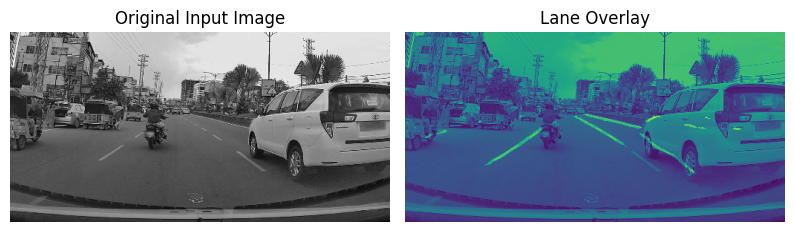

In [23]:


# Define a function to process and visualize the output
def process_and_visualize(input_image_path):
    # Load and preprocess the input image
    input_image = cv2.imread(input_image_path)
    input_image = cv2.resize(input_image, (512, 256))  # Resize to the model's input size
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
    input_image = input_image[..., None]
    input_tensor = torch.from_numpy(input_image).float().permute(2, 0, 1)  # Convert to tensor

    # Pass the input image through the model
    with torch.no_grad():
        binary_logits, instance_logits = enet_model(input_tensor.unsqueeze(0))

    # Post-process the model's output
    binary_seg = torch.argmax(binary_logits, dim=1).squeeze().numpy()
    instance_seg = torch.argmax(instance_logits, dim=1).squeeze().numpy()

    # Convert the binary segmentation mask to grayscale
    binary_seg_grayscale = np.zeros_like(input_image)
    binary_seg_grayscale[binary_seg == 1] = 255  # White color for lanes

    # Overlay the binary segmentation mask on the input image
    output_image = input_image.copy()
    output_image = cv2.addWeighted(output_image, 0.7, binary_seg_grayscale, 0.3, gamma=0)

    # Visualize the results
    plt.figure(figsize=(12, 6))


    plt.subplot(1,3,1)
    plt.imshow(input_image, cmap='gray')  # Use grayscale colormap for consistent appearance
    plt.title('Original Input Image')
    plt.axis('off')

    # Plot the input image and lane-detected image side by side
    plt.subplot(1,3,2)
    plt.imshow(output_image)  # Use grayscale colormap for consistent appearance
    plt.title('Lane Overlay')
    plt.axis('off')


    plt.tight_layout()
    plt.show()

# Replace 'input_image.jpg' with the path to your test image
input_image_path = r'C:\Users\OM SHIV\OneDrive\Desktop\trafficGanMV\dataset\test\images\56_frame_1075.png'
process_and_visualize(input_image_path)



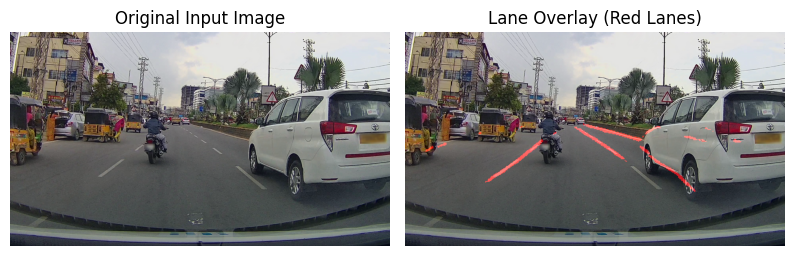

In [26]:


# Define a function to process and visualize the output
def process_and_visualize(input_image_path):
    # Load and preprocess the input image
    original_image = cv2.imread(input_image_path)  # Read the original image
    input_image = cv2.resize(original_image, (512, 256))  # Resize to the model's input size
    input_image_gray = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    input_image_gray = input_image_gray[..., None]
    input_tensor = torch.from_numpy(input_image_gray).float().permute(2, 0, 1)  # Convert to tensor

    # Pass the input image through the model
    with torch.no_grad():
        binary_logits, instance_logits = enet_model(input_tensor.unsqueeze(0))

    # Post-process the model's output
    binary_seg = torch.argmax(binary_logits, dim=1).squeeze().numpy()

    # Resize the binary segmentation mask to the original image size
    binary_seg_resized = cv2.resize(binary_seg, (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Create a red mask for detected lanes
    red_mask = np.zeros_like(original_image)
    red_mask[binary_seg_resized == 1] = [0, 0, 255]  # Red color for detected lanes

    # Overlay the red mask on the original image
    output_image = cv2.addWeighted(original_image, 1, red_mask, 0.7, gamma=0)

    # Visualize the results
    plt.figure(figsize=(12, 6))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for visualization
    plt.title('Original Input Image')
    plt.axis('off')

    # Lane overlay image
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for visualization
    plt.title('Lane Overlay (Red Lanes)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Replace with the path to your test image
input_image_path = r'C:\Users\OM SHIV\OneDrive\Desktop\trafficGanMV\dataset\test\images\56_frame_1075.png'
process_and_visualize(input_image_path)


In [27]:


# Define a function to apply lane detection on a single frame
def apply_lane_detection(frame):
    original_image = frame  # Original frame
    input_image = cv2.resize(original_image, (512, 256))  # Resize to model input size
    input_image_gray = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    input_image_gray = input_image_gray[..., None]
    input_tensor = torch.from_numpy(input_image_gray).float().permute(2, 0, 1)  # Convert to tensor

    # Pass the input image through the model
    with torch.no_grad():
        binary_logits, instance_logits = enet_model(input_tensor.unsqueeze(0))

    # Post-process the model's output
    binary_seg = torch.argmax(binary_logits, dim=1).squeeze().numpy()

    # Resize the binary segmentation mask to the original image size
    binary_seg_resized = cv2.resize(binary_seg, (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Create a red mask for detected lanes
    red_mask = np.zeros_like(original_image)
    red_mask[binary_seg_resized == 1] = [0, 0, 255]  # Red color for detected lanes

    # Overlay the red mask on the original image
    output_frame = cv2.addWeighted(original_image, 1, red_mask, 0.7, gamma=0)

    return output_frame

# Open the input video
input_video_path = r'C:\Users\OM SHIV\OneDrive\Desktop\trafficGanMV\output_video.avi'
cap = cv2.VideoCapture(input_video_path)

# Get the video properties (frame width, height, and fps)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Create a VideoWriter to save the output video
output_video_path = 'output_lane_detection_video1.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

# Process each frame of the input video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Apply lane detection on the frame
    output_frame = apply_lane_detection(frame)

    # Write the output frame to the video
    out.write(output_frame)

    # Optionally display the frame (can be commented out if not needed)
    cv2.imshow('Lane Detection', output_frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and writer
cap.release()
out.release()
cv2.destroyAllWindows()


In [29]:


# Define a function to apply lane detection on a single frame
def apply_lane_detection(frame):
    original_image = frame  # Original frame
    input_image = cv2.resize(original_image, (512, 256))  # Resize to model input size
    input_image_gray = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    input_image_gray = input_image_gray[..., None]
    input_tensor = torch.from_numpy(input_image_gray).float().permute(2, 0, 1)  # Convert to tensor

    # Pass the input image through the model
    with torch.no_grad():
        binary_logits, instance_logits = enet_model(input_tensor.unsqueeze(0))

    # Post-process the model's output
    binary_seg = torch.argmax(binary_logits, dim=1).squeeze().numpy()

    # Resize the binary segmentation mask to the original image size
    binary_seg_resized = cv2.resize(binary_seg, (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Create a red mask for detected lanes
    red_mask = np.zeros_like(original_image)
    red_mask[binary_seg_resized == 1] = [0, 0, 255]  # Red color for detected lanes

    # Overlay the red mask on the original image
    output_frame = cv2.addWeighted(original_image, 1, red_mask, 0.7, gamma=0)

    return output_frame

# Open the input video
input_video_path = r"C:\Users\OM SHIV\ultralytics\runs\detect\predict6\output_video.avi"
cap = cv2.VideoCapture(input_video_path)

# Get the video properties (frame width, height, and fps)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Create a VideoWriter to save the output video
output_video_path = 'output_lane_detection_video2.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

# Process each frame of the input video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Apply lane detection on the frame
    output_frame = apply_lane_detection(frame)

    # Write the output frame to the video
    out.write(output_frame)

    # Optionally display the frame (can be commented out if not needed)
    cv2.imshow('Lane Detection', output_frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and writer
cap.release()
out.release()
cv2.destroyAllWindows()


In [30]:
from ultralytics import YOLO

# Load the trained model
model = YOLO(r'C:\Users\OM SHIV\OneDrive\Desktop\trafficGanMV\yolo11n (1).pt')

# Run prediction on a video
results = model.predict(source=r'C:\Users\OM SHIV\OneDrive\Desktop\trafficGanMV\output_lane_detection_video2.avi', save=True, conf=0.25)



WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/300) C:\Users\OM SHIV\OneDrive\Desktop\trafficGanMV\output_lane_detection_video2.avi: 384x640 1 person, 3 cars, 15.9ms
video 1/1 (frame 2/300) C:\Users\OM SHIV\OneDrive\Desktop\trafficGanMV\output_lane_detection_video2.avi: 384x640 (no detections), 11.0ms
video 1/1 (frame 3/300) C:\Users\OM SHIV\OneDrive\Desktop\trafficGanMV\output_lane_detection_video2.avi: 384x640 1 person, 1 car, 1 bus, 9.9ms
video 1/1 (frame 4/300) C:\Users\OM SHIV